# Exploratory Data Analysis (EDA)

## Notebook Roadmap
1. Executive summary for non-technical stakeholders.
2. Data provenance and basic structure checks.
3. Distribution, correlation, and feature-behavior analysis.
4. Missing values, outliers, and bias-related caveats.
5. Actionable next steps for feature engineering and modeling.


## 1. Executive Summary

This dataset tracks diabetes-related hospital encounters and whether patients were readmitted (`NO`, `>30`, `<30`).
For business users, the key question is simple: **which patient and visit patterns indicate higher readmission risk**.

### Key Findings (Plain Language)
- Readmission is imbalanced, so model evaluation must focus on recall and macro-F1, not accuracy only.
- Prior utilization (`number_inpatient`, `number_emergency`, `number_outpatient`) is a strong risk signal.
- Clinical burden (`number_diagnoses`) and intake channel (`admission_source_id`) are important contributors.
- Categorical effects exist, but many raw medication columns add noise unless aggregated.

In [50]:
import os
import sys
import importlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().resolve().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

import notebook_checks as notebook_checks_mod
import styling.styling as styling_mod

importlib.reload(notebook_checks_mod)
importlib.reload(styling_mod)

from config import get_config
from styling.plots import (
    add_comorbidity_features,
    add_medication_adjustment_features,
    add_specialty_logic,
    analyze_all_categorical_outliers,
    categorize_icd9_vectorized,
    clean_admission_sources,
    clean_payer_codes,
    compute_feature_influence_table,
    get_outlier_summary,
    plot_a1c_bin_distribution,
    plot_benchmark_grouped_risk,
    plot_categorical_impact,
    plot_correlation_heatmap,
    plot_cramers_v_heatmap,
    plot_med_adjustment_binary,
    plot_med_adjustment_panels,
    plot_medication_risk_yes_only,
    plot_numeric_kde_by_readmitted,
    plot_specialty_logic_risk,
    plot_target_distribution,
    plot_top_outlier_boxplots,
    refine_diagnosis_categories,
)

run_basic_data_quality_gates = notebook_checks_mod.run_basic_data_quality_gates
assert_target_mapping_complete = notebook_checks_mod.assert_target_mapping_complete
assert_no_missing_values = notebook_checks_mod.assert_no_missing_values
build_reproducibility_footer = notebook_checks_mod.build_reproducibility_footer

apply_notebook_style = styling_mod.apply_notebook_style
build_eda_output_paths = styling_mod.build_eda_output_paths
build_artifact_path = styling_mod.build_artifact_path
save_table_snapshot = styling_mod.save_table_snapshot

cfg = get_config(PROJECT_ROOT)
apply_notebook_style()
output_path, table_output_path = build_eda_output_paths(PROJECT_ROOT)

NOTEBOOK_ID = '01'
def fig_path(section_id: str, slug: str):
    return build_artifact_path(output_path, NOTEBOOK_ID, section_id, slug, 'png')

def table_path(section_id: str, slug: str, extension: str = 'png'):
    return build_artifact_path(table_output_path, NOTEBOOK_ID, section_id, slug, extension)


## 2. Data Provenance


#### Selected Dataset: Diabetes 130-US Hospitals (1999-2008)

- **Target variable**: readmission class (`NO`, `>30`, `<30`)
- **Source**: [UCI ML Repository](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)
- **Citation**: Clore, J., Cios, K., DeShazo, J., & Strack, B. (2014). *Diabetes 130-US Hospitals for Years 1999-2008*.
- **Usage note**: This is retrospective observational data; the analysis is predictive, not causal.


### Data Overview

- **Volume**: ~100k encounters in the original dataset; this notebook runs on the training split.
- **Variety**: Demographics, admission context, diagnoses, utilization intensity, and medication status.
- **Veracity**: Missing tokens (`?`), sparse fields (`weight`, `max_glu_serum`), and coded categories require cleaning.
- **Value**: Supports early-risk triage and discharge planning.
- **Scope risk**: Healthcare practices from 1999-2008 may not fully represent current care workflows.


Load the interim training split used for EDA (no leakage from test data).


In [51]:
data = pd.read_csv(cfg.interim_train_path)
test_data = pd.read_csv(cfg.interim_test_path)

quality_report = run_basic_data_quality_gates(
    train_df=data,
    test_df=test_data,
    target_col=cfg.target_col,
    required_cols=[cfg.target_col, 'encounter_id', 'patient_nbr'],
    leakage_id_cols=['encounter_id'],
)
display(quality_report)

save_table_snapshot(
    quality_report,
    table_path('02', 'quality_gates_report'),
    title='EDA - Data Quality Gates (Schema, Leakage, Class Checks)',
    index=False,
)
quality_report.to_csv(table_path('02', 'quality_gates_report', 'csv'), index=False)

print(f"Train shape: {data.shape}")
print(f"Target distribution: {data['readmitted'].value_counts(normalize=True).round(3).to_dict()}")

data.head(3)


,readmitted,count,percentage,dataset
0,NO,43891,53.91,train
1,>30,28436,34.93,train
2,<30,9085,11.16,train
3,NO,10973,53.91,test
4,>30,7109,34.93,test
5,<30,2272,11.16,test


Train shape: (81412, 50)
Target distribution: {'NO': 0.539, '>30': 0.349, '<30': 0.112}


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,288505380,88660782,Caucasian,Male,[50-60),?,2,7,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,>30
1,311400854,86940774,Caucasian,Female,[70-80),?,1,1,7,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
2,83604810,1252890,AfricanAmerican,Male,[40-50),?,2,1,1,1,...,No,No,No,No,No,No,No,Ch,Yes,NO


## 3. Class Distribution

Readmission class balance determines both baseline difficulty and metric strategy.


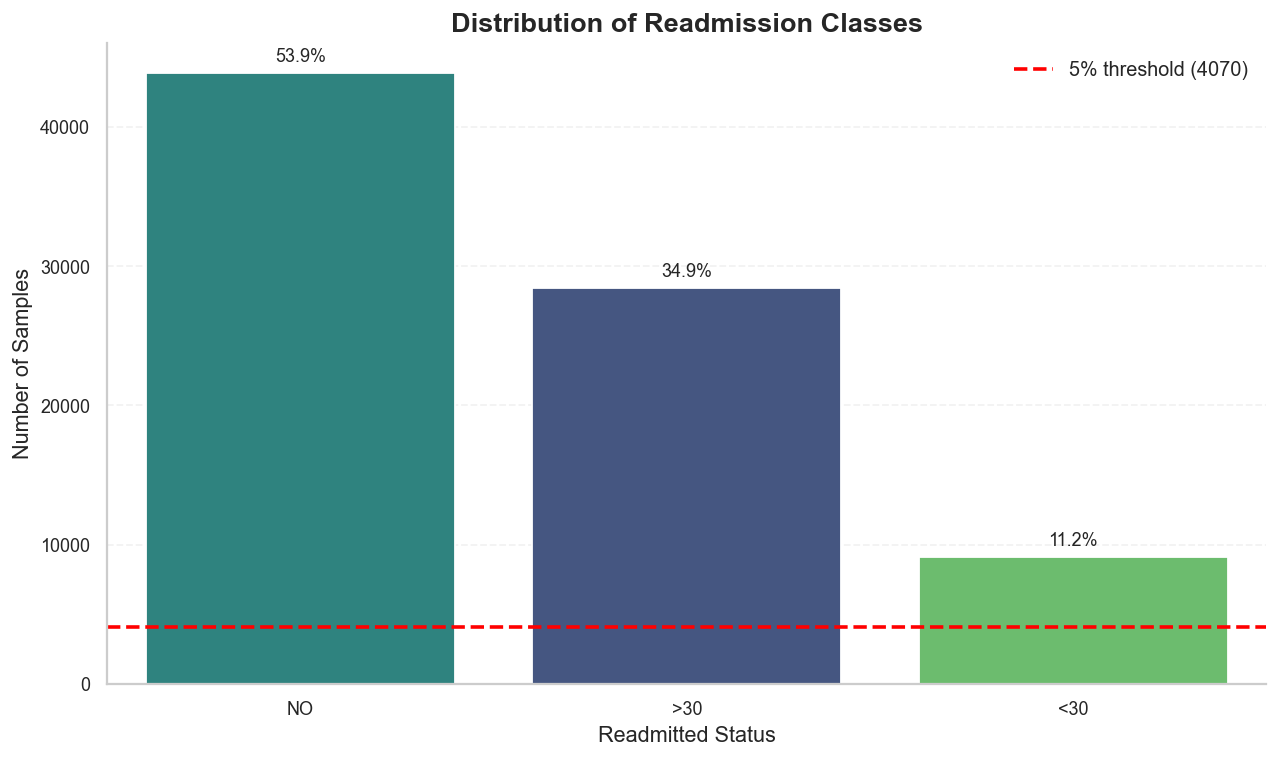

In [52]:
plot_target_distribution(
    data,
    target_col='readmitted',
    order=['NO', '>30', '<30'],
    threshold_pct=0.05,
    save_path=fig_path('03', 'class_distribution'),
)
plt.show()


## 4. Variable Summary

This section documents column completeness and uniqueness before deep feature analysis.


In [53]:
schema_table = pd.DataFrame({
    'column': data.columns,
    'dtype': data.dtypes.astype(str).values,
    'non_null_count': data.notna().sum().values,
    'missing_count': data.replace('?', pd.NA).isna().sum().values,
    'missing_pct': (data.replace('?', pd.NA).isna().mean().values * 100).round(2),
    'n_unique': data.nunique(dropna=False).values,
})

schema_table = schema_table.sort_values(['missing_pct', 'n_unique'], ascending=[False, False])
display(schema_table)

save_table_snapshot(
    schema_table,
    table_path('04', 'schema_overview'),
    title='EDA - Schema Overview (Missingness and Cardinality)',
    index=False,
)
schema_table.to_csv(table_path('04', 'schema_overview', 'csv'), index=False)


,column,dtype,non_null_count,missing_count,missing_pct,n_unique
5,weight,object,81412,78822,96.82,10
22,max_glu_serum,object,4250,77162,94.78,4
23,A1Cresult,object,13645,67767,83.24,4
11,medical_specialty,object,81412,39948,49.07,69
10,payer_code,object,81412,32153,39.49,18
2,race,object,81412,1820,2.24,6
20,diag_3,object,81412,1144,1.41,761
19,diag_2,object,81412,286,0.35,707
18,diag_1,object,81412,18,0.02,700
0,encounter_id,int64,81412,0,0.00,81412


### Column Documentation

The detailed business definitions live in the project data dictionary. In this notebook, we focus on statistical behavior and predictive relevance.


##  5. Key Correlations & Feature Insights

#### Analysis Approach

1. **Numerical behavior**: distribution shape and class-wise density.
2. **Correlation scan**: relationship strength with encoded readmission target.
3. **Categorical behavior**: benchmarked risk splits for diagnosis, demographics, payer/admission context, and medication features.


### Numerical Features

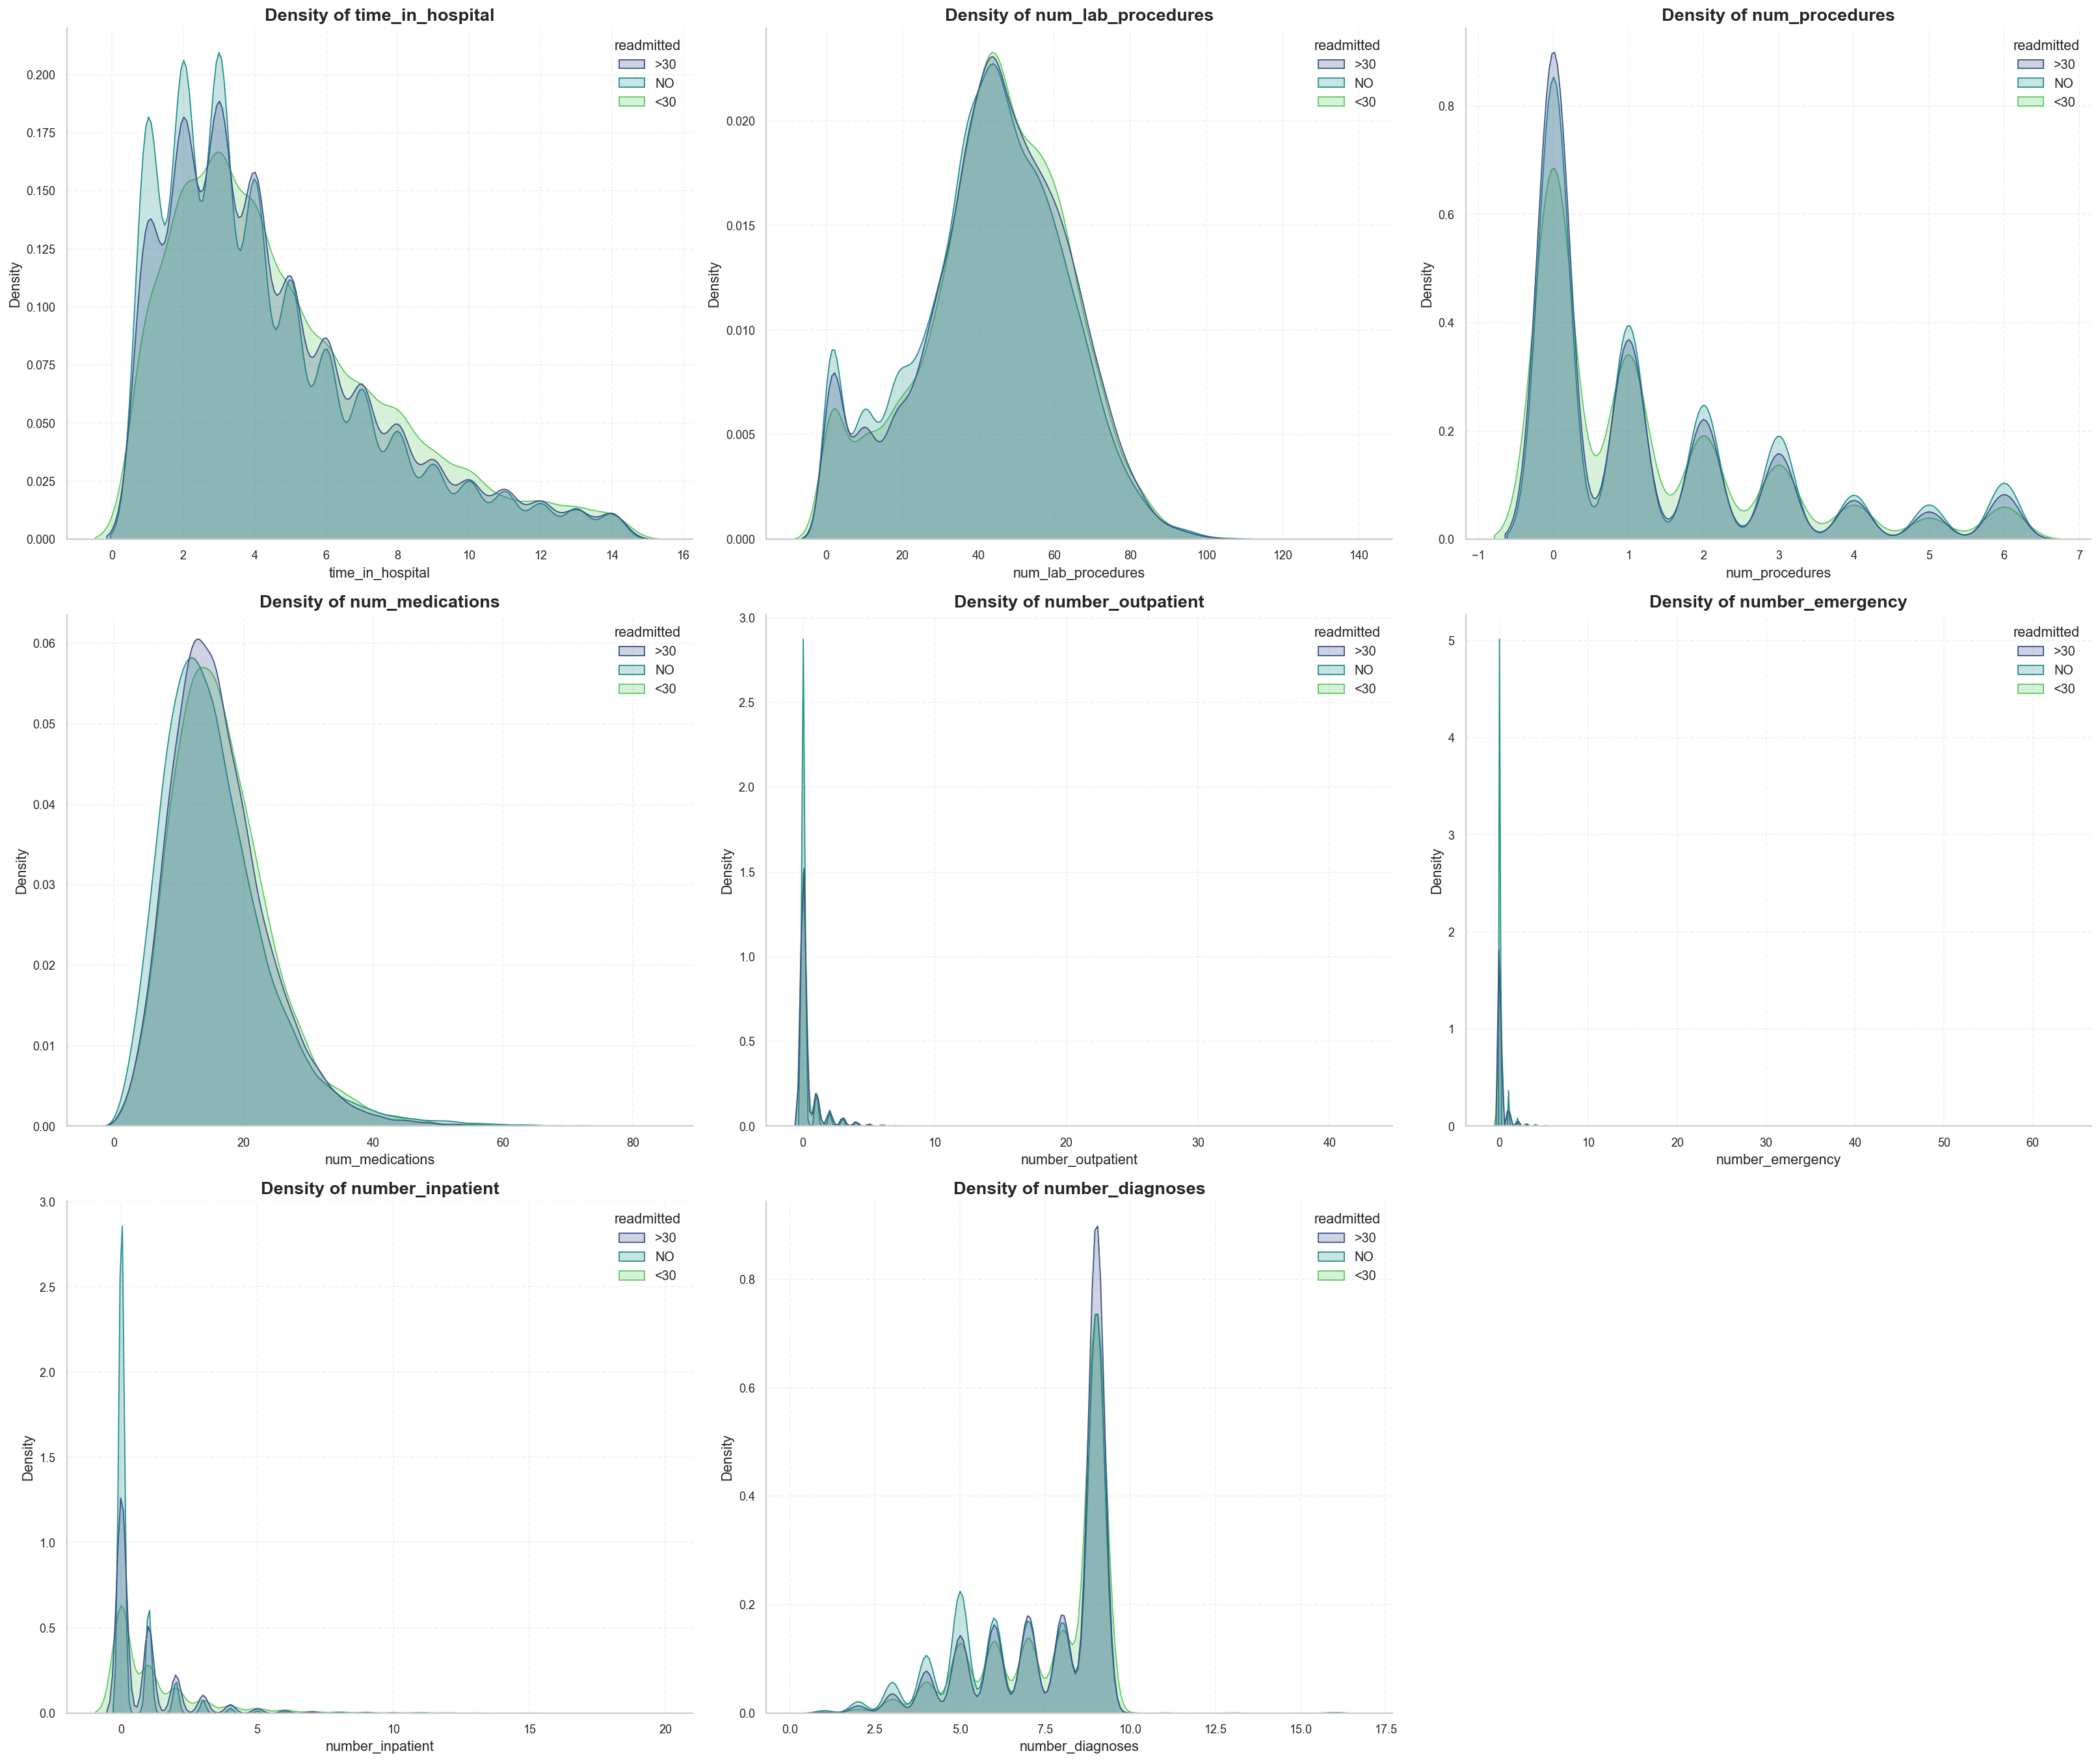

In [54]:
# 2. Identify numerical columns (excluding the target)
num_cols = ['time_in_hospital',
            'num_lab_procedures', 'num_procedures', 'num_medications',
            'number_outpatient', 'number_emergency', 'number_inpatient',
            'number_diagnoses'
            ]

plot_numeric_kde_by_readmitted(
    data=data,
    num_cols=num_cols,
    hue='readmitted',
    n_cols=3,
    save_path=fig_path('05', 'numeric_density_grid'),
)
plt.show()


Numerical features are only moderately correlated individually; the strongest single linear signal remains limited, so interactions and grouped categorical effects are necessary.


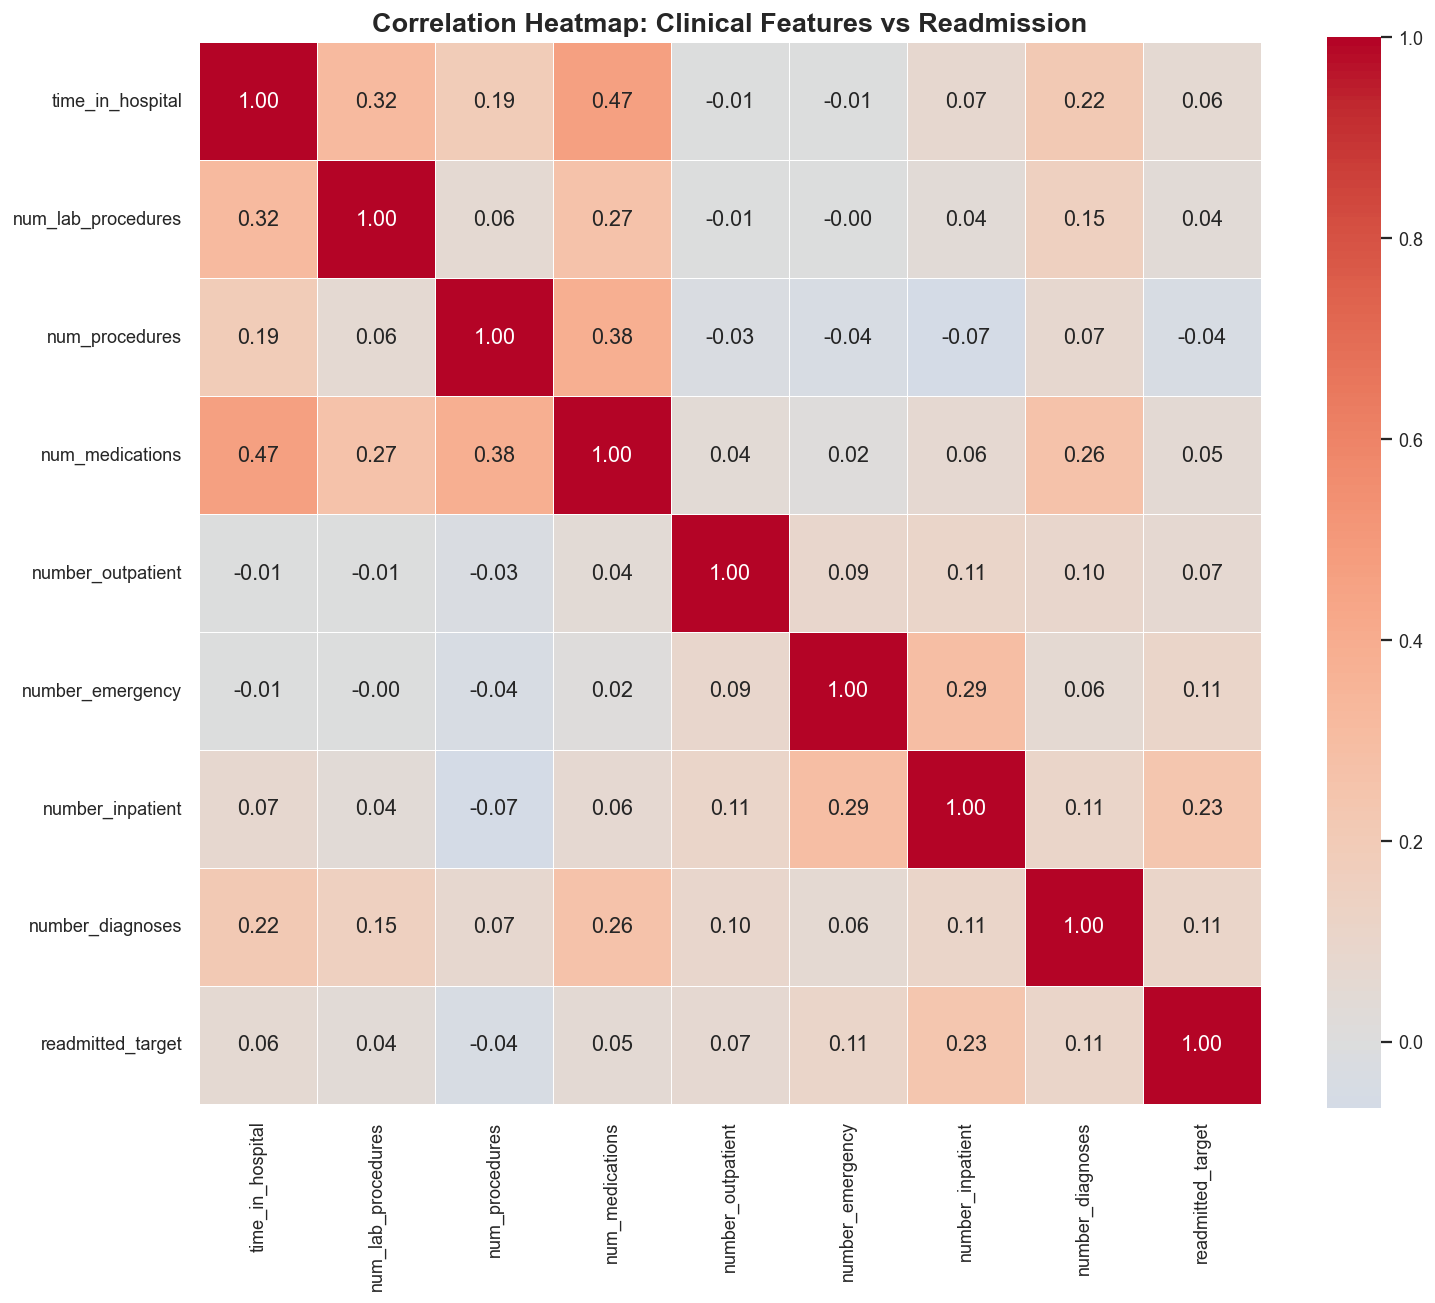

,corr_with_readmitted_target
number_inpatient,0.234945
number_emergency,0.111271
number_diagnoses,0.105072
number_outpatient,0.068523
time_in_hospital,0.057178
num_medications,0.051230
num_procedures,-0.037764
num_lab_procedures,0.036065


In [55]:
# 1. Prepare data for correlation
target_map = {
    'NO': 0,
    '>30': 1,
    '<30': 2
}
assert_target_mapping_complete(data['readmitted'], target_map, 'eda_train')

corr_matrix = plot_correlation_heatmap(
    data=data,
    num_cols=num_cols,
    target_col='readmitted',
    target_map=target_map,
    save_path=fig_path('05', 'numeric_correlation_heatmap'),
)
plt.show()

numeric_target_corr = (
    corr_matrix['readmitted_target']
    .drop('readmitted_target')
    .sort_values(key=lambda s: s.abs(), ascending=False)
    .rename('corr_with_readmitted_target')
    .to_frame()
)
display(numeric_target_corr)

save_table_snapshot(
    numeric_target_corr.reset_index().rename(columns={'index': 'feature'}),
    table_path('05', 'numeric_target_correlation'),
    title='EDA - Numerical Features vs Readmission Target',
    index=False,
)
numeric_target_corr.to_csv(table_path('05', 'numeric_target_correlation', 'csv'))


### Categorical Features

Focus areas: diagnosis groups, admission context, demographics, payer grouping, A1C behavior, and medication-adjustment summary features.


#### Diagnosis Codes

Generating EDA plots...


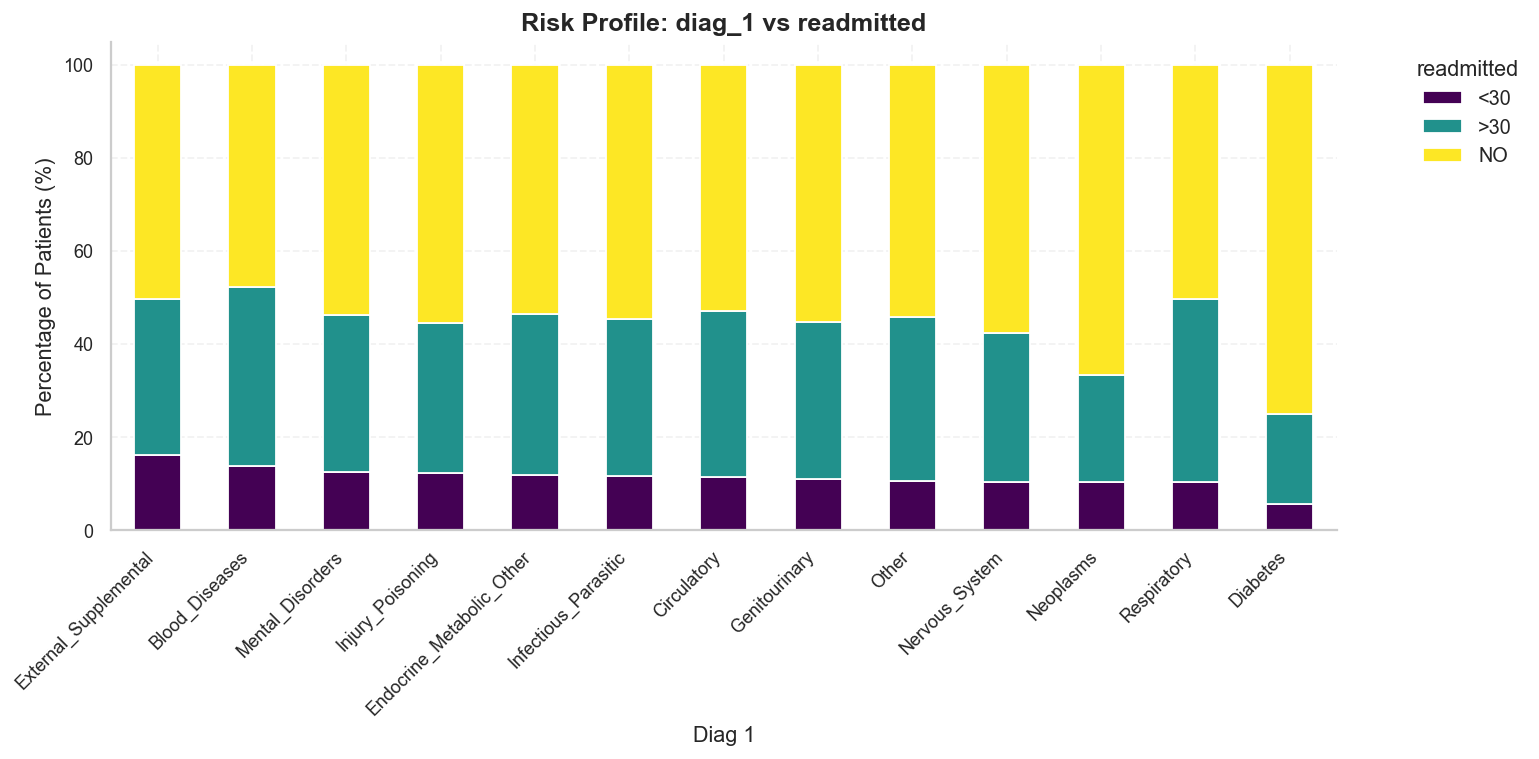

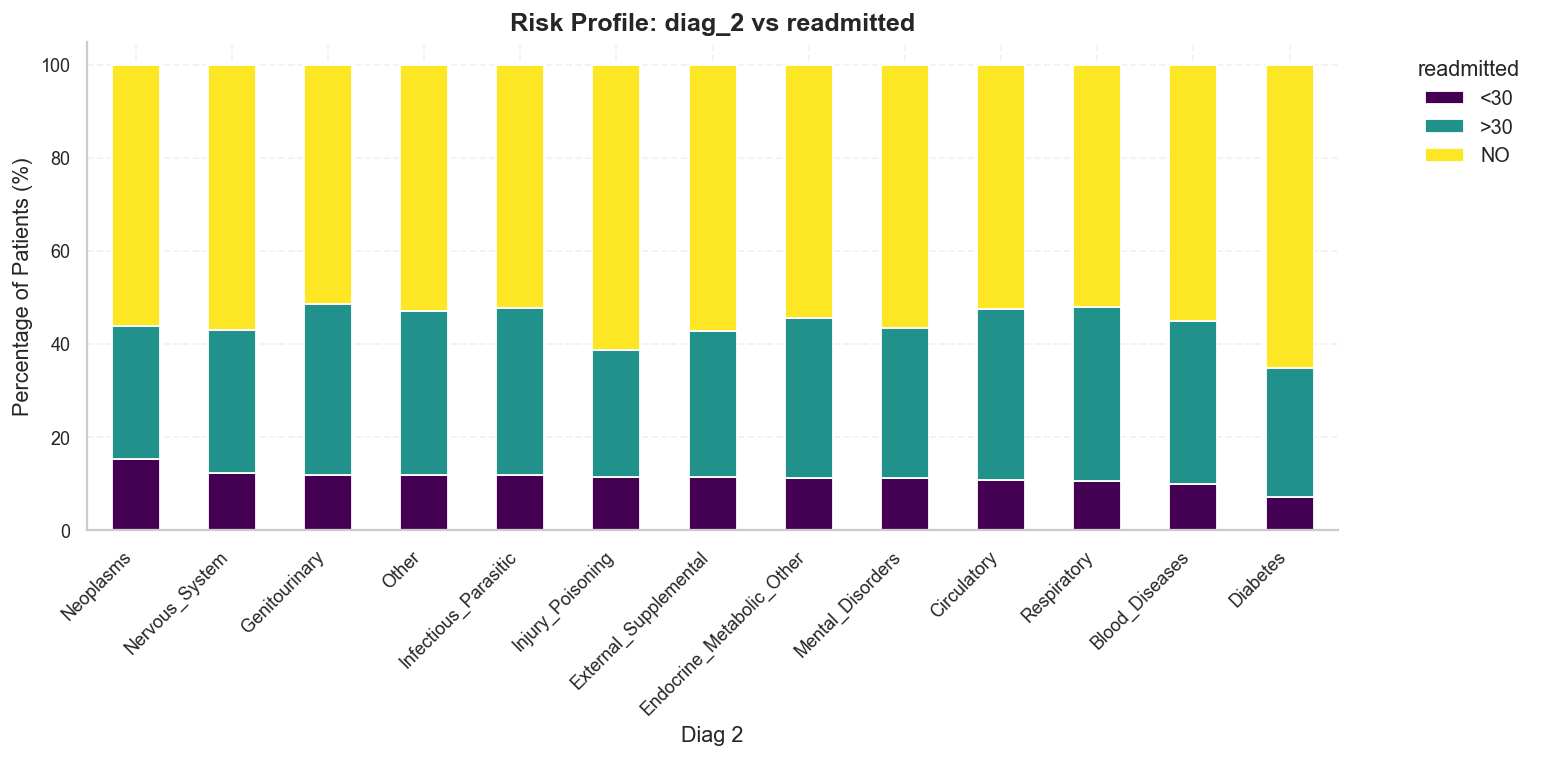

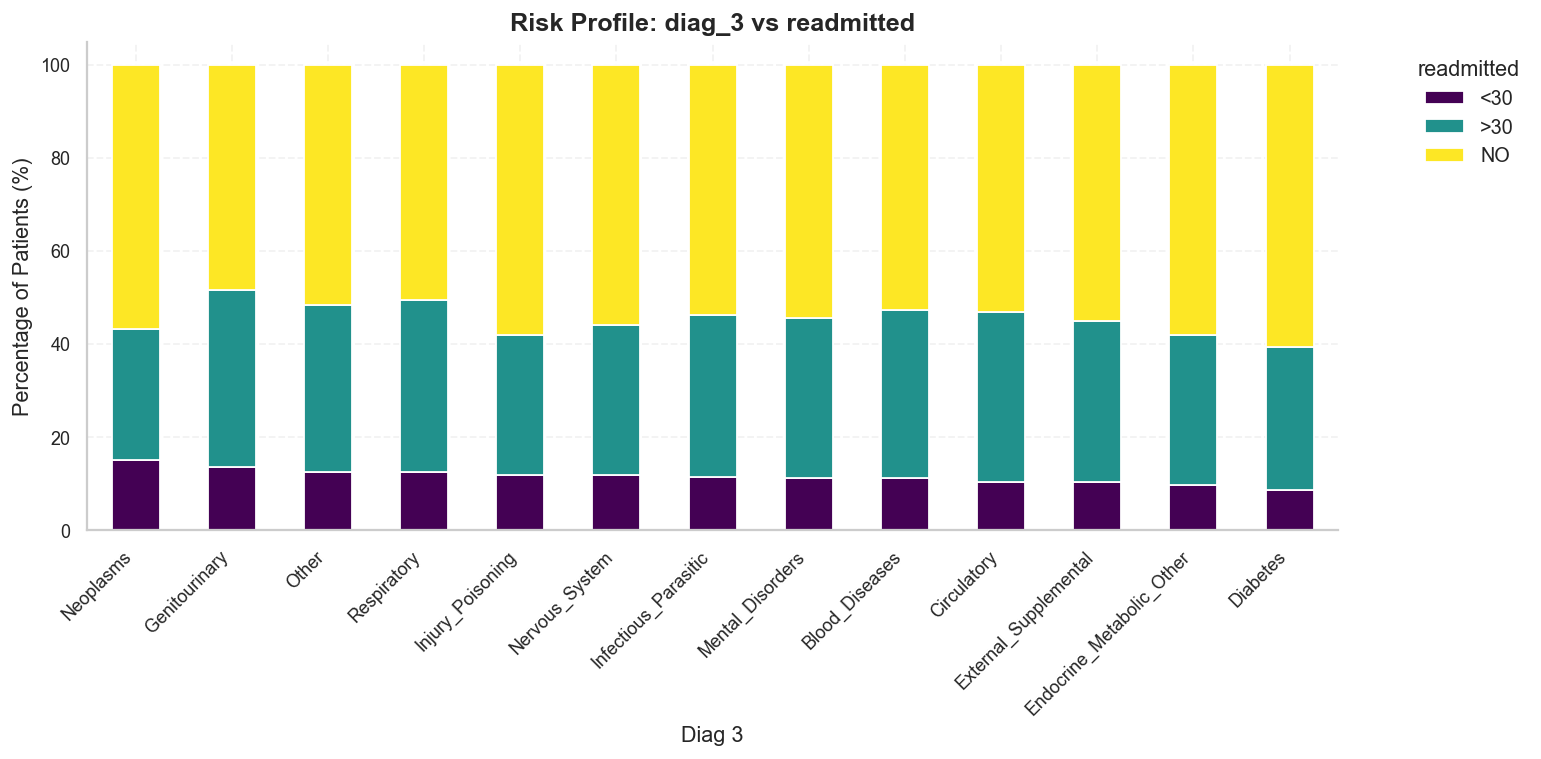

In [56]:
# 2. FEATURE ENGINEERING FLOW
# Load ONLY the training data for EDA
df_eda = data.copy()

# Define columns to process
diag_cols = ['diag_1', 'diag_2', 'diag_3']

# Apply all transformations
for col in diag_cols:
    df_eda[col] = categorize_icd9_vectorized(df_eda[col])

df_eda = refine_diagnosis_categories(df_eda, diag_cols)
df_eda = add_comorbidity_features(df_eda, target_diags=diag_cols)

# Run EDA visualizations
print('Generating EDA plots...')
for diag_col in diag_cols:
    plot_categorical_impact(
        df_eda,
        diag_col,
        target='readmitted',
        save_path=fig_path('05', f'impact_{diag_col}'),
    )
    plt.show()


### Readmission Race, Age, Gender

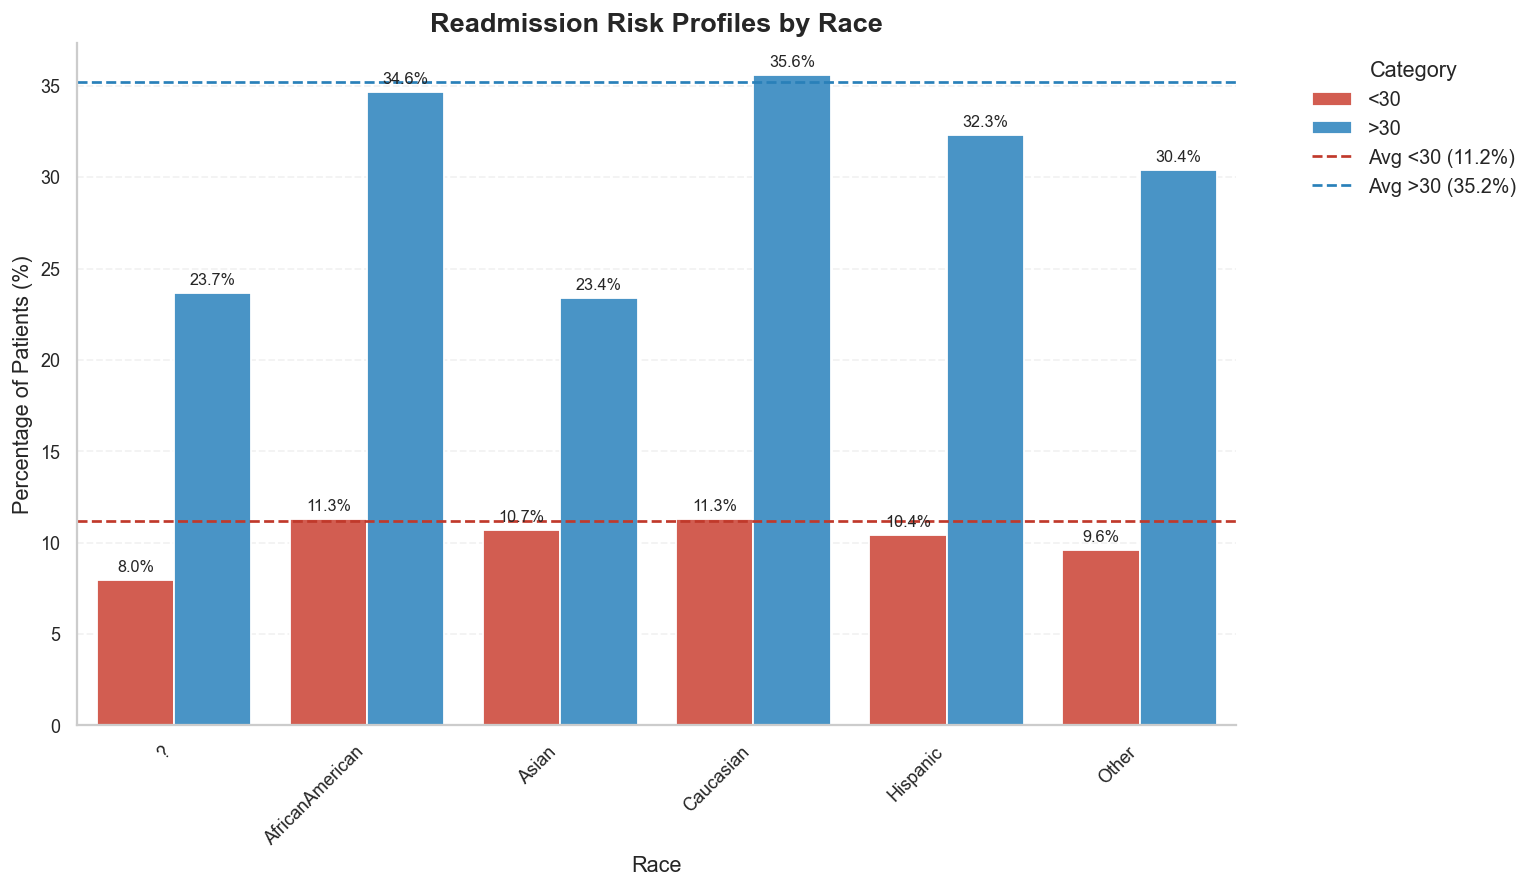

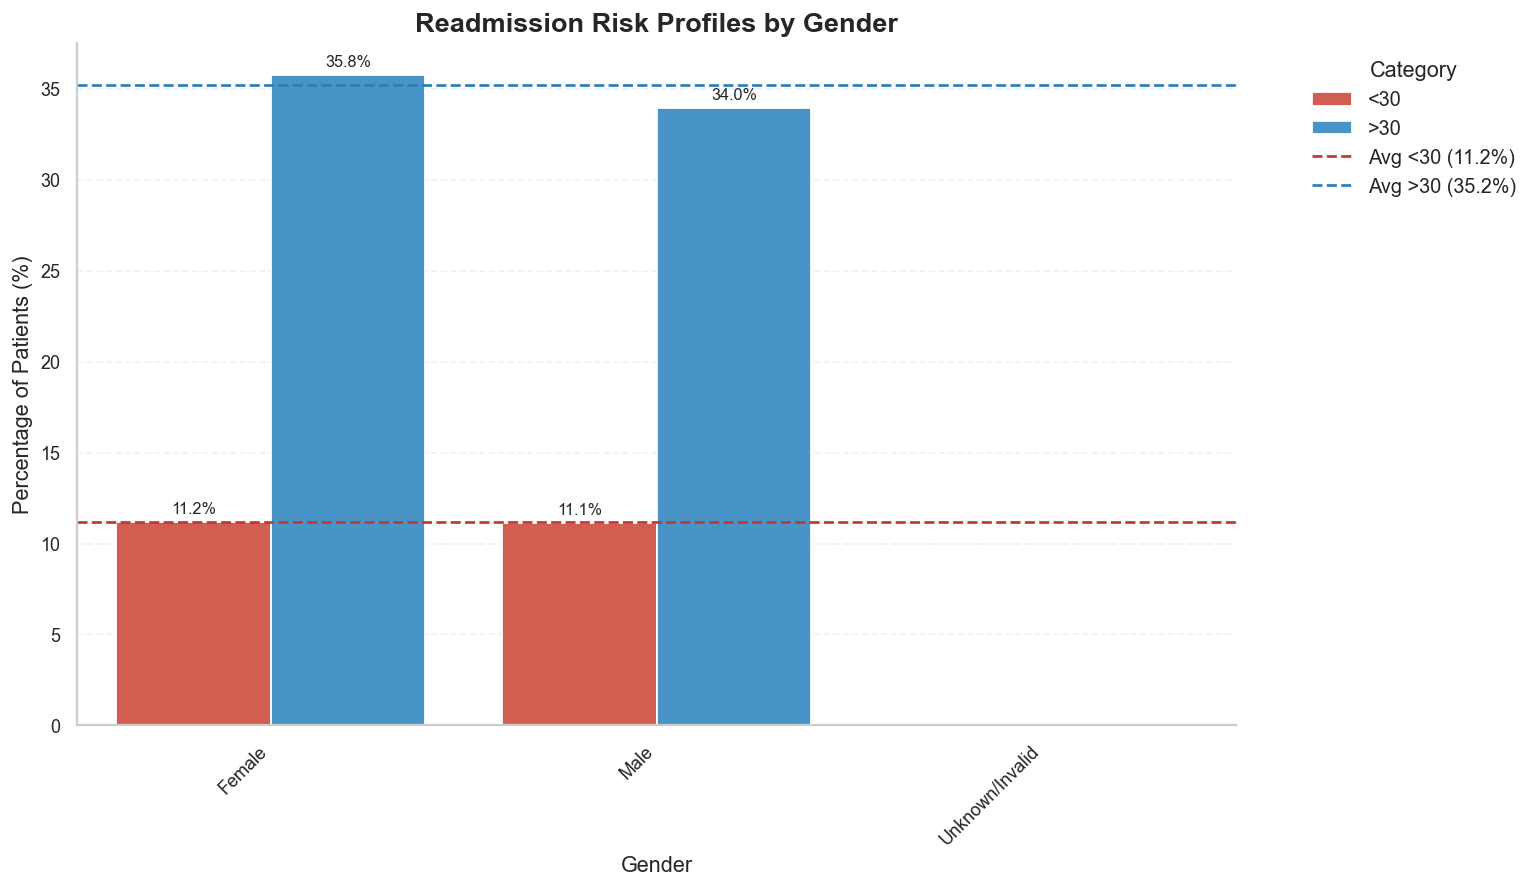

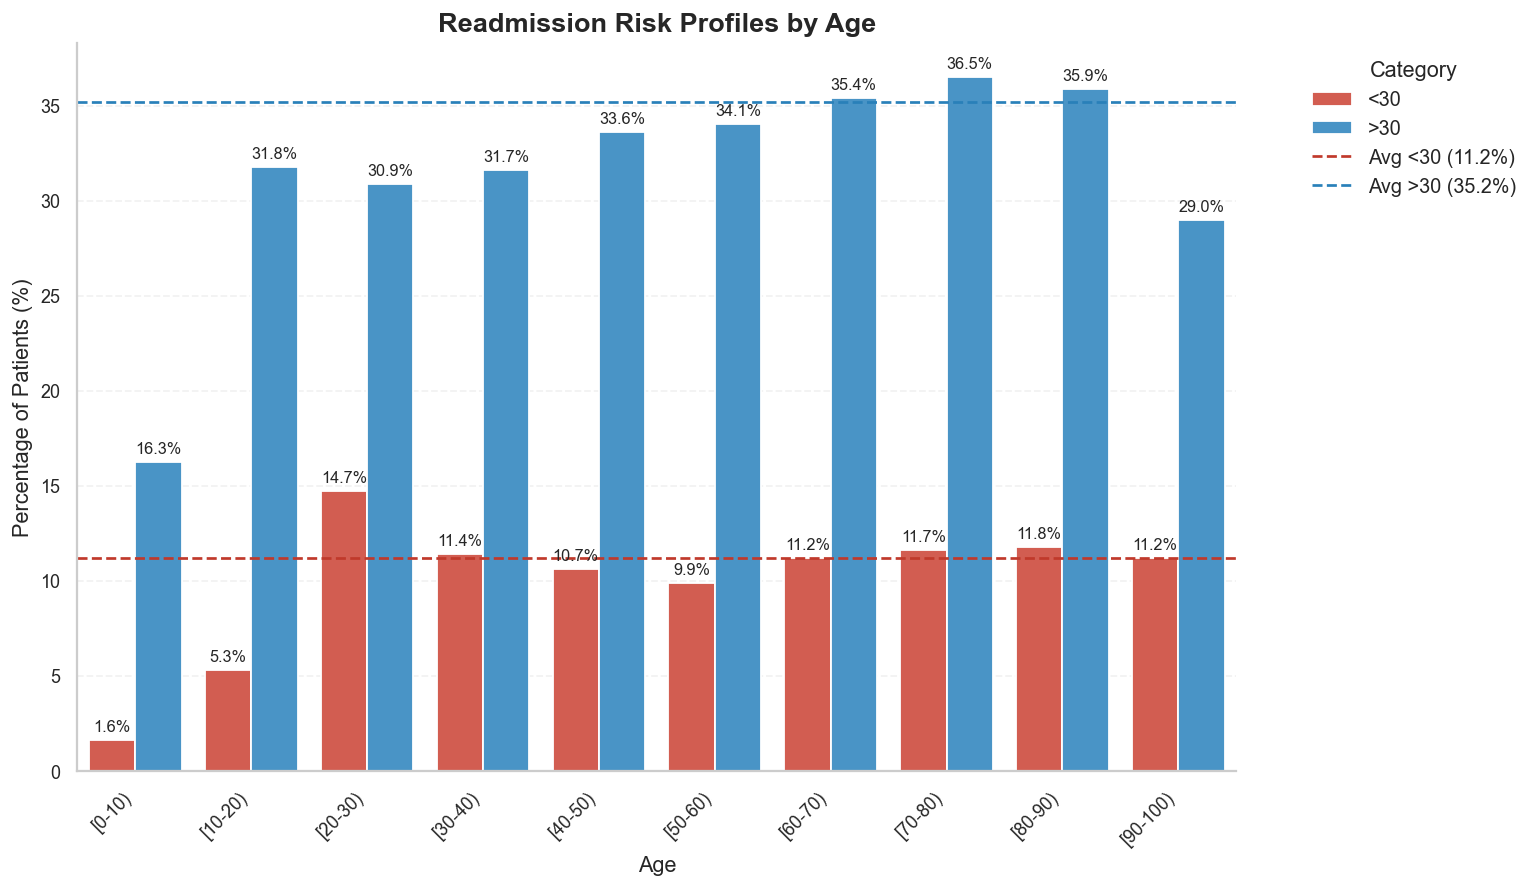

In [57]:
# 1. Configuration
avg_under_30 = 11.2
avg_over_30 = 35.2

demo_cols = ['race', 'gender', 'age']

# 2. Plotting Loop
for col in demo_cols:
    plot_benchmark_grouped_risk(
        df=df_eda,
        group_col=col,
        avg_under_30=avg_under_30,
        avg_over_30=avg_over_30,
        title=f'Readmission Risk Profiles by {col.title()}',
        x_label=col.title(),
        rotate_xticks=45,
        save_path=fig_path('05', f'demo_comparison_{col}'),
    )
    plt.show()


### Payment Method

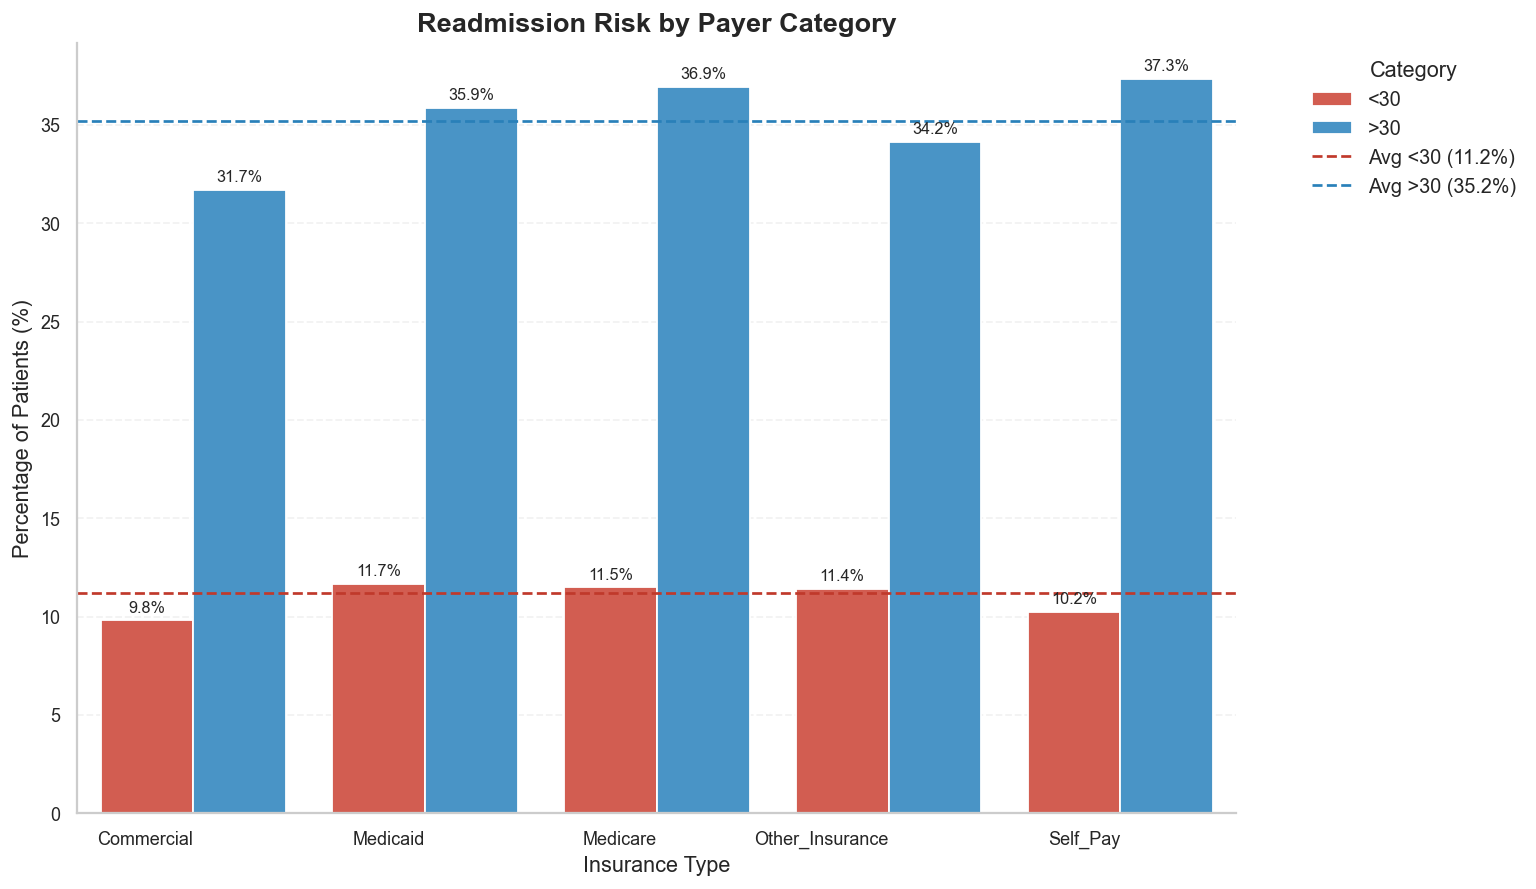

In [58]:
# 1. Setup & Benchmarks
avg_under_30 = 11.2
avg_over_30 = 35.2

# 2. Apply the Grouping
df_eda = clean_payer_codes(df_eda)

# 3. Plot
plot_benchmark_grouped_risk(
    df=df_eda,
    group_col='payer_code',
    avg_under_30=avg_under_30,
    avg_over_30=avg_over_30,
    title='Readmission Risk by Payer Category',
    x_label='Insurance Type',
    rotate_xticks=0,
    save_path=fig_path('05', 'risk_by_payer_code'),
)
plt.show()


### Admission Source

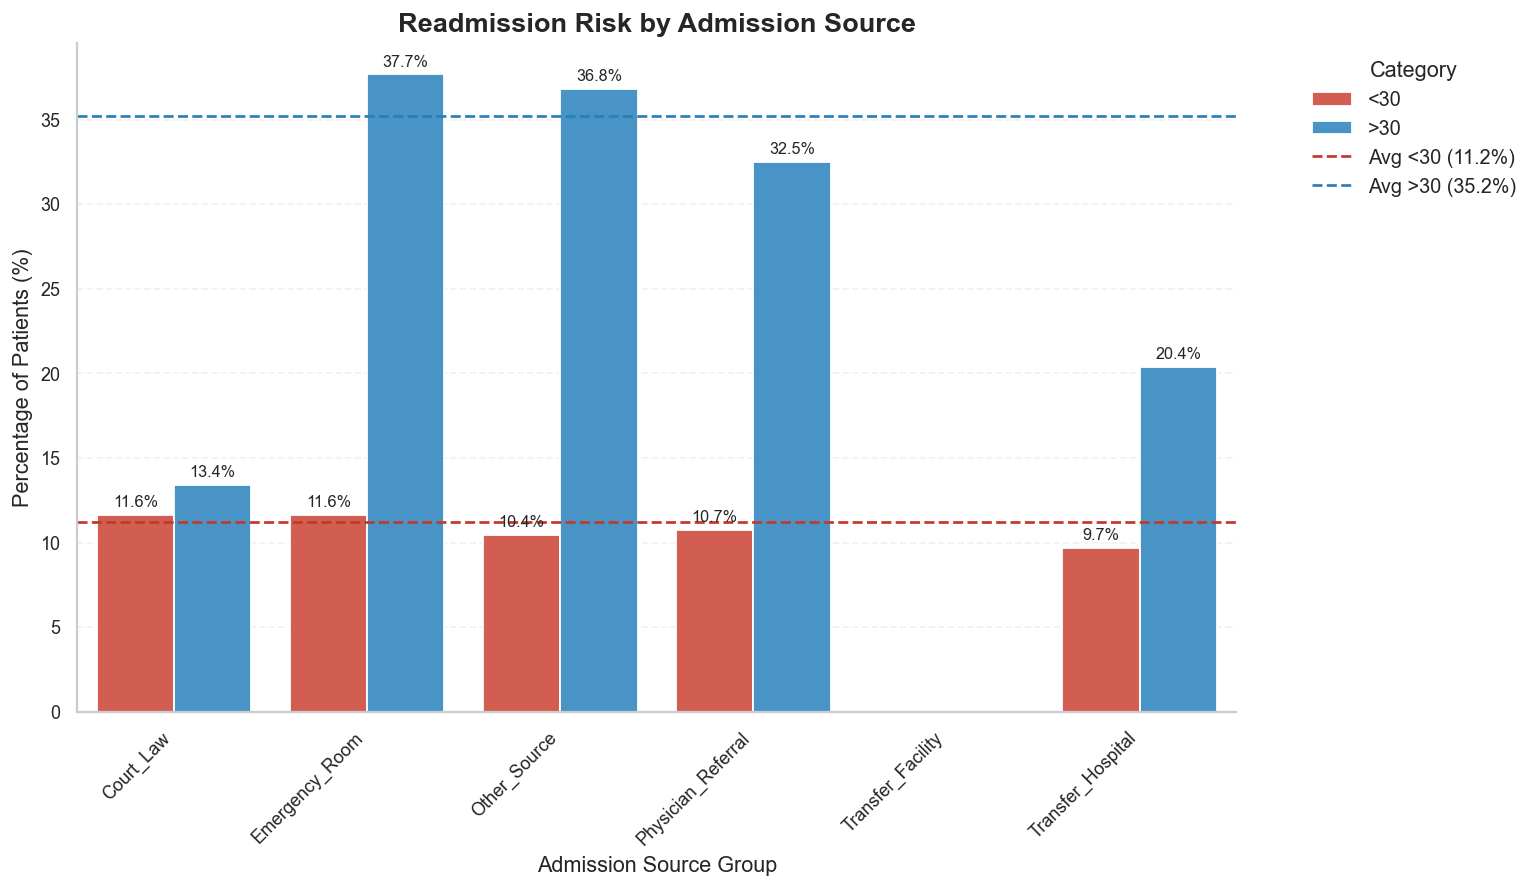

In [59]:
# 1. Setup & Benchmarks
avg_under_30 = 11.2
avg_over_30 = 35.2

# 2. Apply the Grouping Logic
df_eda = clean_admission_sources(df_eda)

# 3. Plot
plot_benchmark_grouped_risk(
    df=df_eda,
    group_col='admission_source_id',
    avg_under_30=avg_under_30,
    avg_over_30=avg_over_30,
    title='Readmission Risk by Admission Source',
    x_label='Admission Source Group',
    rotate_xticks=45,
    save_path=fig_path('05', 'risk_by_admission_source'),
)
plt.show()


### Diabetes Medications

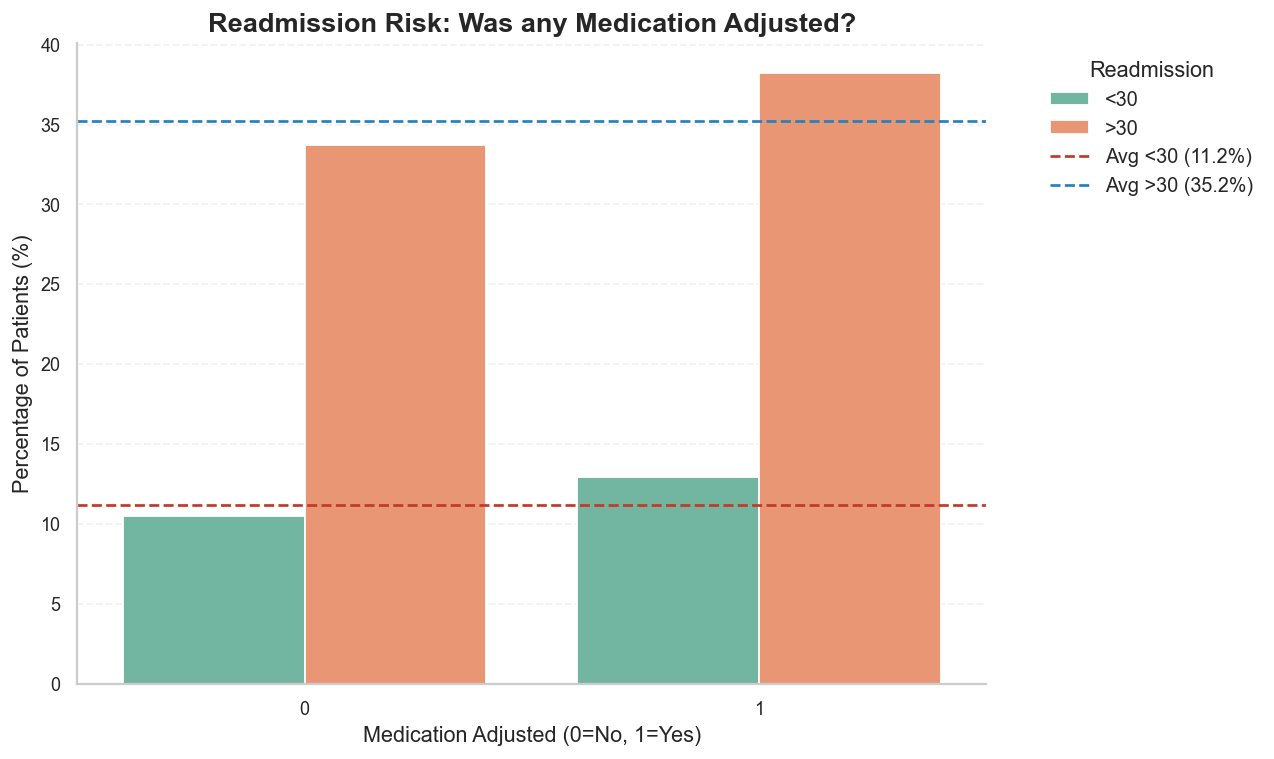

/Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/src/styling/plots.py:339: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], data=df, x="readmitted", y="adj_med_ratio", order=order, palette="mako")


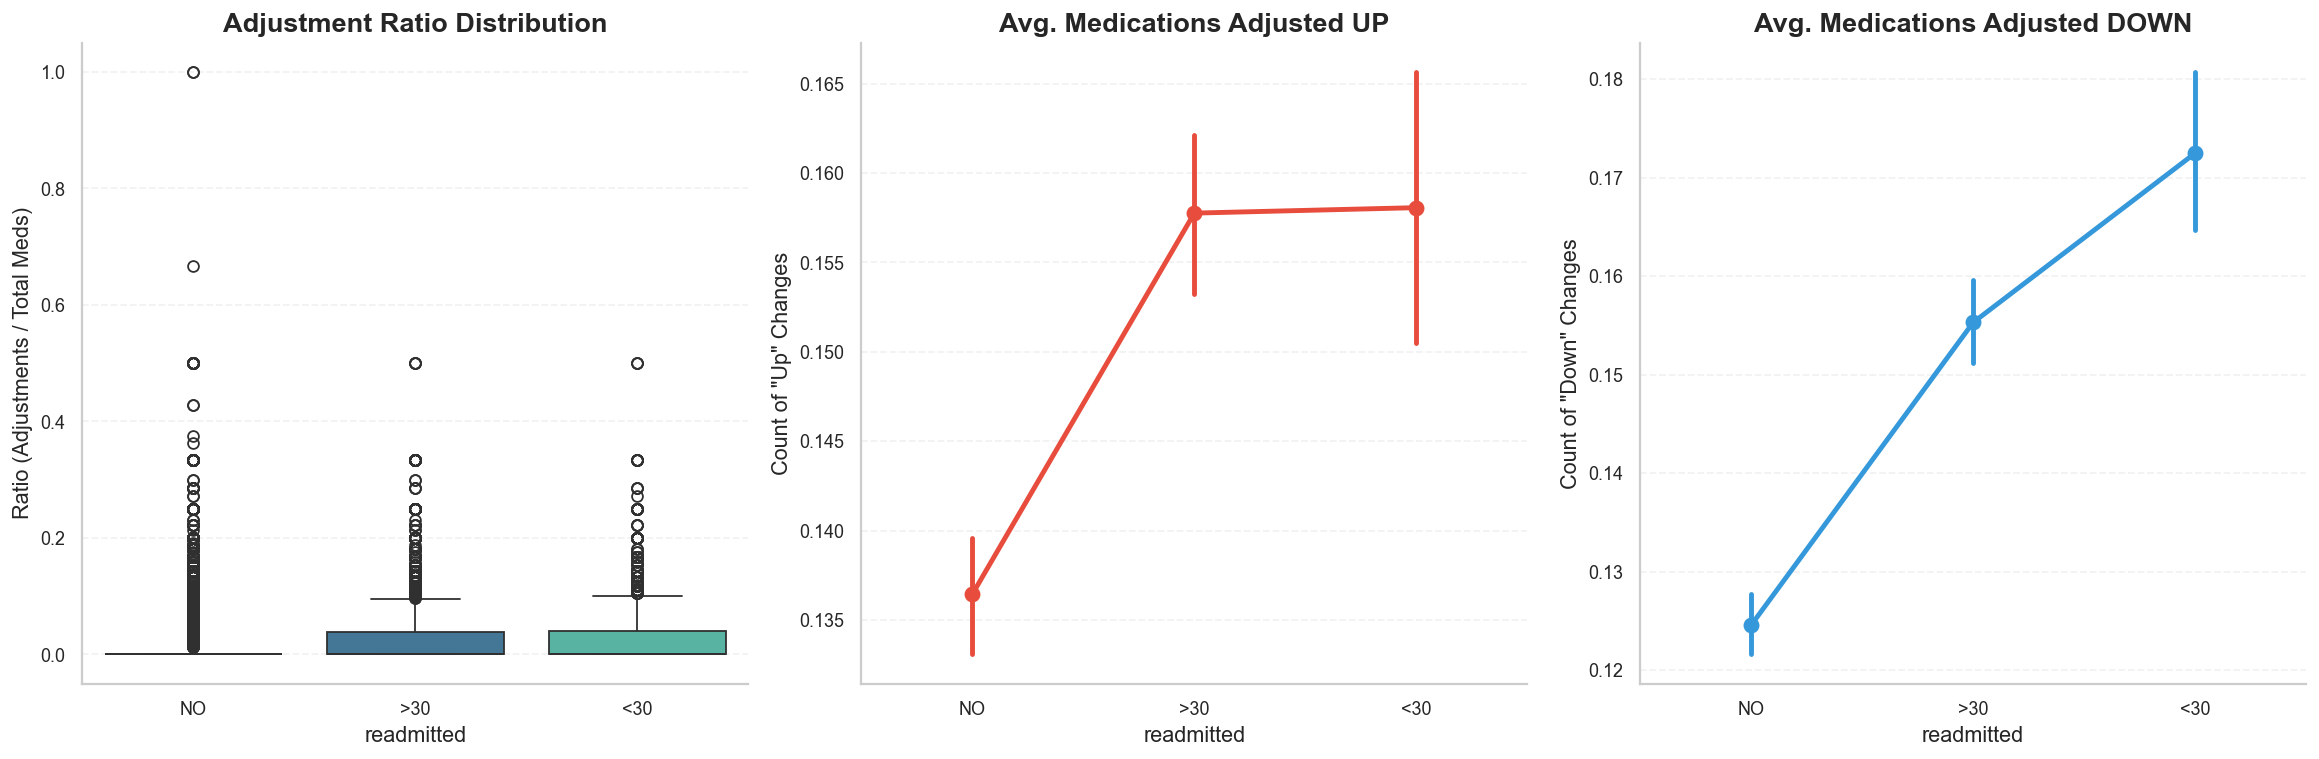

In [60]:
med_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# 2. Feature engineering
# Must be done before converting to Yes/No
df_eda = add_medication_adjustment_features(df_eda, med_cols)

# 3. Benchmarks
avg_under_30 = 11.2
avg_over_30 = 35.2

# 4. Plot 1: Binary Medication Adjustment
plot_med_adjustment_binary(
    df_eda,
    avg_under_30=avg_under_30,
    avg_over_30=avg_over_30,
    save_path=fig_path('05', 'med_adjustment_binary'),
)
plt.show()

# 5. Plot 2: Adjustment panel
plot_med_adjustment_panels(
    df_eda,
    order=['NO', '>30', '<30'],
    save_path=fig_path('05', 'med_adjustment_panel'),
)
plt.show()


### Binary Medication Yes / No

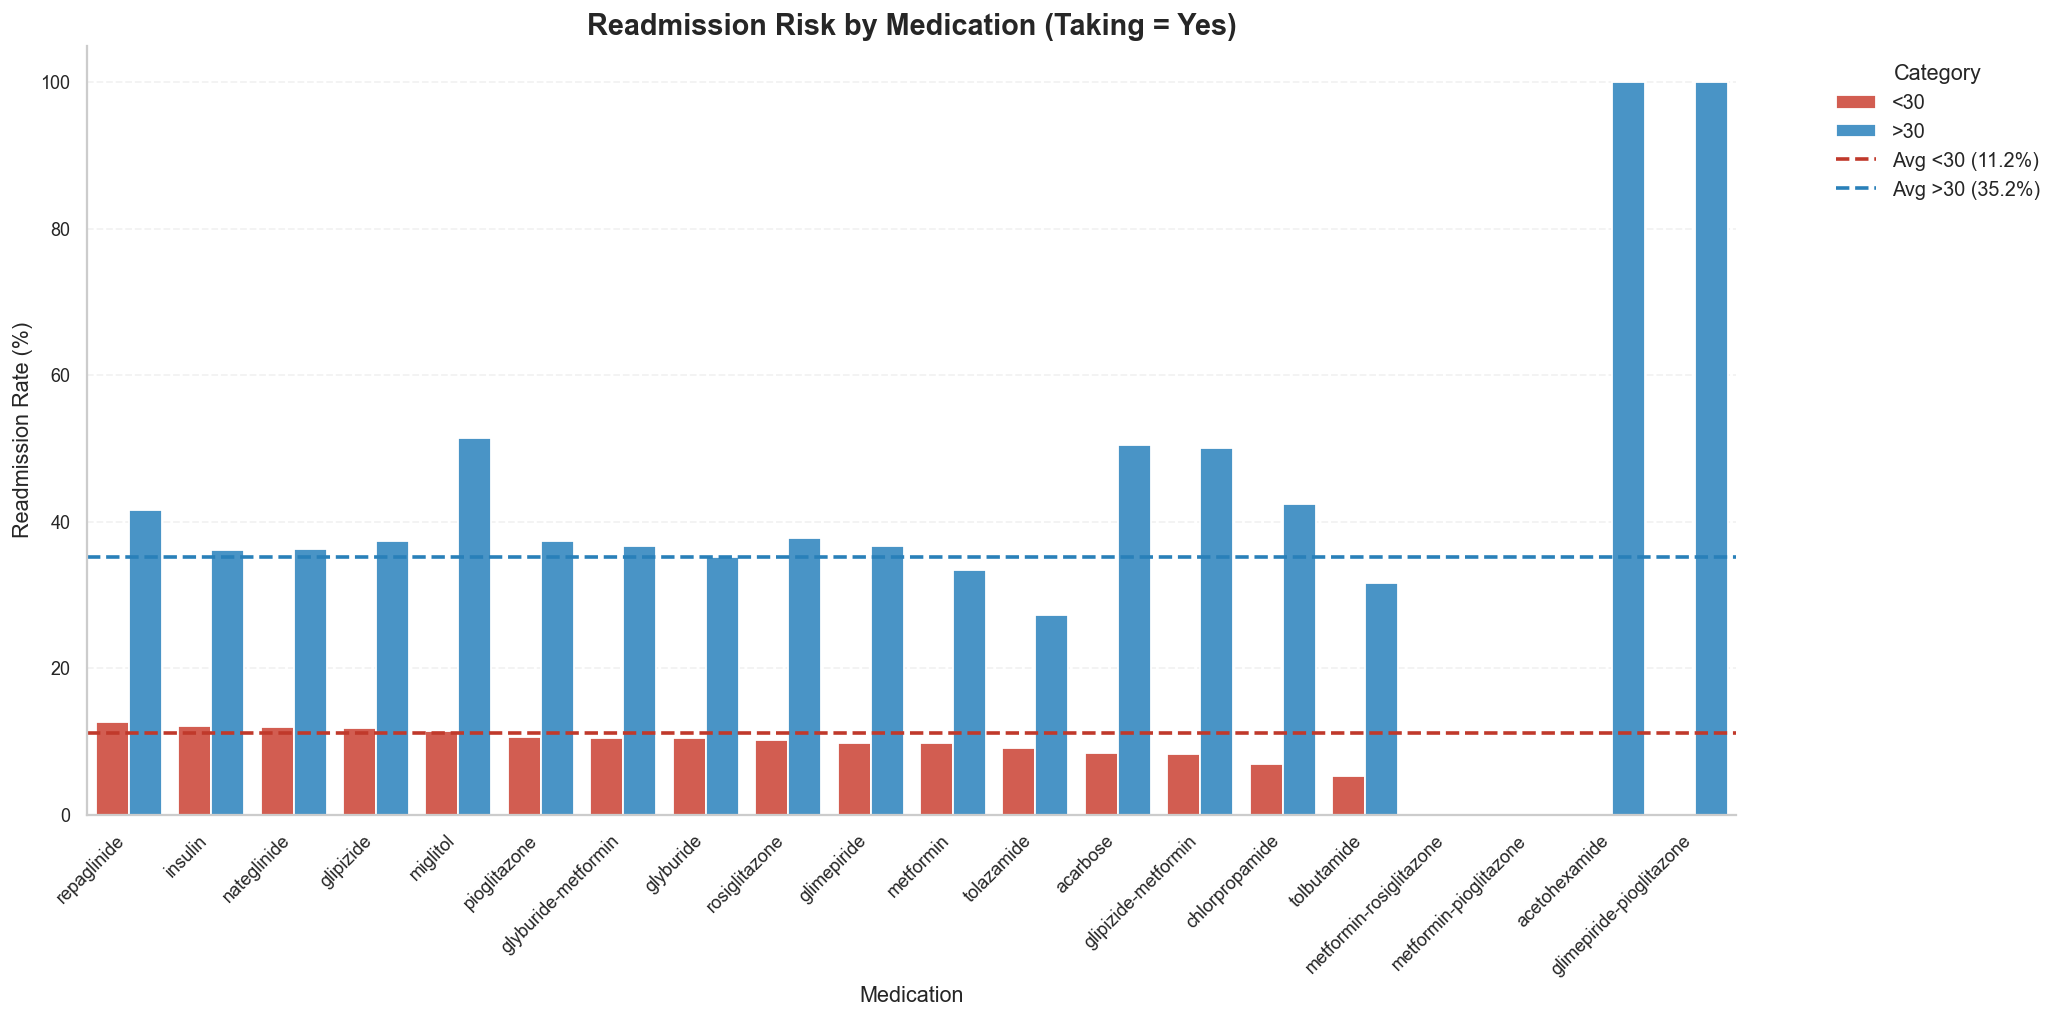

In [61]:
# 1. Setup
avg_under_30 = 11.2
avg_over_30 = 35.2

# 2. Medication risk (taking medication = Yes)
plot_medication_risk_yes_only(
    df=df_eda,
    med_cols=med_cols,
    avg_under_30=avg_under_30,
    avg_over_30=avg_over_30,
    save_path=fig_path('05', 'medication_risk_final'),
)
plt.show()


### A1C Result Bins


[nan '>8' '>7' 'Norm']


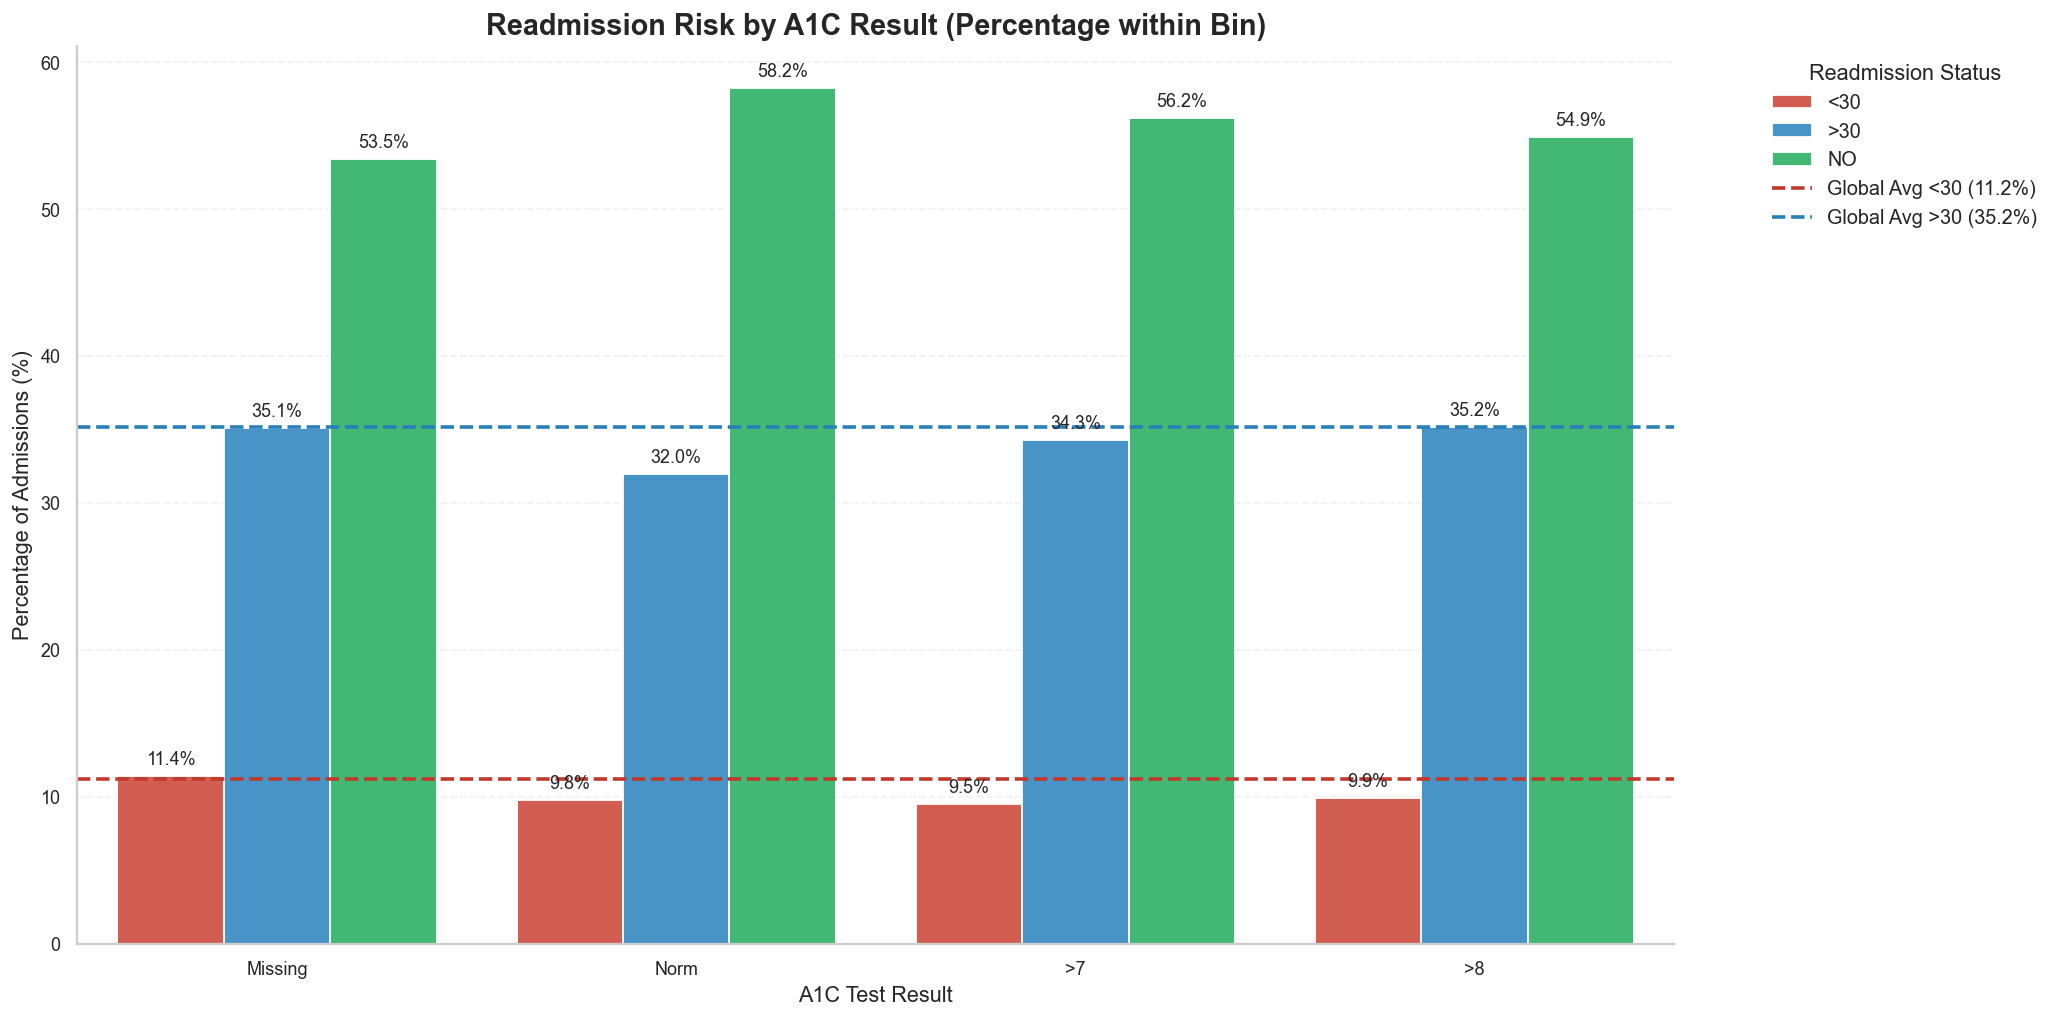

In [62]:
print(df_eda['A1Cresult'].unique())

df_eda['A1Cresult'] = df_eda['A1Cresult'].fillna('Missing')

# Benchmarks
avg_under_30 = 11.2
avg_over_30 = 35.2

plot_a1c_bin_distribution(
    df=df_eda,
    avg_under_30=avg_under_30,
    avg_over_30=avg_over_30,
    a1c_order=['Missing', 'Norm', '>7', '>8'],
    save_path=fig_path('05', 'a1c_bin_distribution_benchmarks'),
)
plt.show()


### Medical Speciality

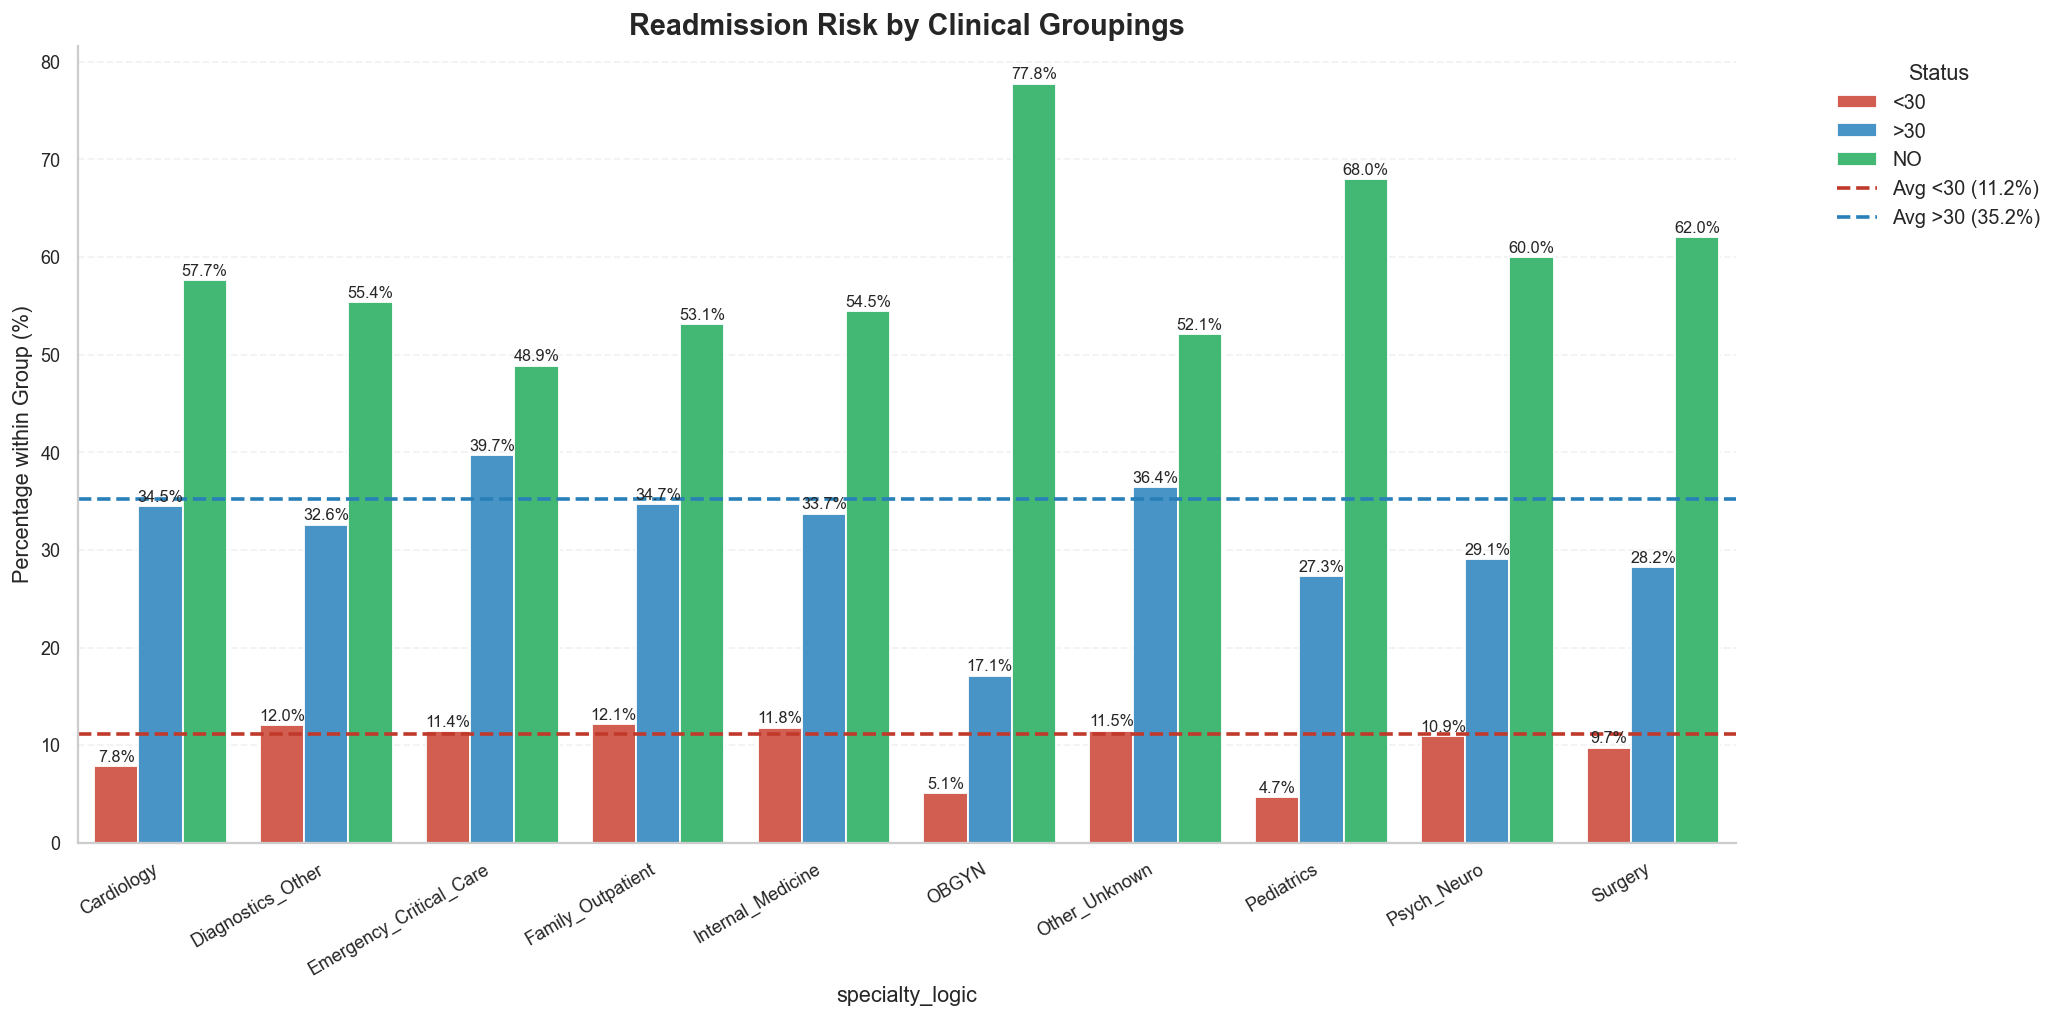

In [63]:
# Apply mapping and handle missing/unknown
df_eda = add_specialty_logic(df_eda)

# Benchmarks
avg_under_30 = 11.2
avg_over_30 = 35.2

plot_specialty_logic_risk(
    df=df_eda,
    avg_under_30=avg_under_30,
    avg_over_30=avg_over_30,
    save_path=fig_path('05', 'risk_by_specialty_logic'),
)
plt.show()


### Consolidated Categorical Analysis

Rebuild a clean EDA frame and evaluate cross-feature associations with Cramer's V.


In [64]:
# 1. Master re-initialization
df_eda = pd.read_csv(cfg.interim_train_path)

# 2. Apply grouping functions
df_eda = clean_payer_codes(df_eda)
df_eda = clean_admission_sources(df_eda)

# 3. Diagnosis engineering
diag_cols = ['diag_1', 'diag_2', 'diag_3']
for col in diag_cols:
    df_eda[col] = categorize_icd9_vectorized(df_eda[col])
df_eda = refine_diagnosis_categories(df_eda, diag_cols)
df_eda = add_comorbidity_features(df_eda, target_diags=diag_cols)

# 4. Medication summary features
med_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]
df_eda = add_medication_adjustment_features(df_eda, med_cols)
for col in med_cols:
    if col in df_eda.columns:
        df_eda[col] = np.where(df_eda[col].astype(str).eq('No'), 'No', 'Yes')

# 5. Specialty grouping
df_eda = add_specialty_logic(df_eda)


In [65]:
# 1. Detect categorical features
cat_features = df_eda.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Found {len(cat_features)} categorical features")

# 2. Track potentially categorical ID-like columns for audit
id_cols = [col for col in df_eda.columns if 'id' in col.lower()]
print(f"ID-like columns for review: {id_cols}")


Found 39 categorical features
ID-like columns for review: ['encounter_id', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide', 'examide', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'has_kidney']


Analyzing associations for: ['race', 'gender', 'age', 'payer_code', 'admission_source_id', 'med_adjusted_binary', 'insulin', 'target', 'count_adjusted_up', 'count_adjusted_down', 'diag_1', 'diag_2', 'diag_3', 'A1Cresult', 'specialty_logic']


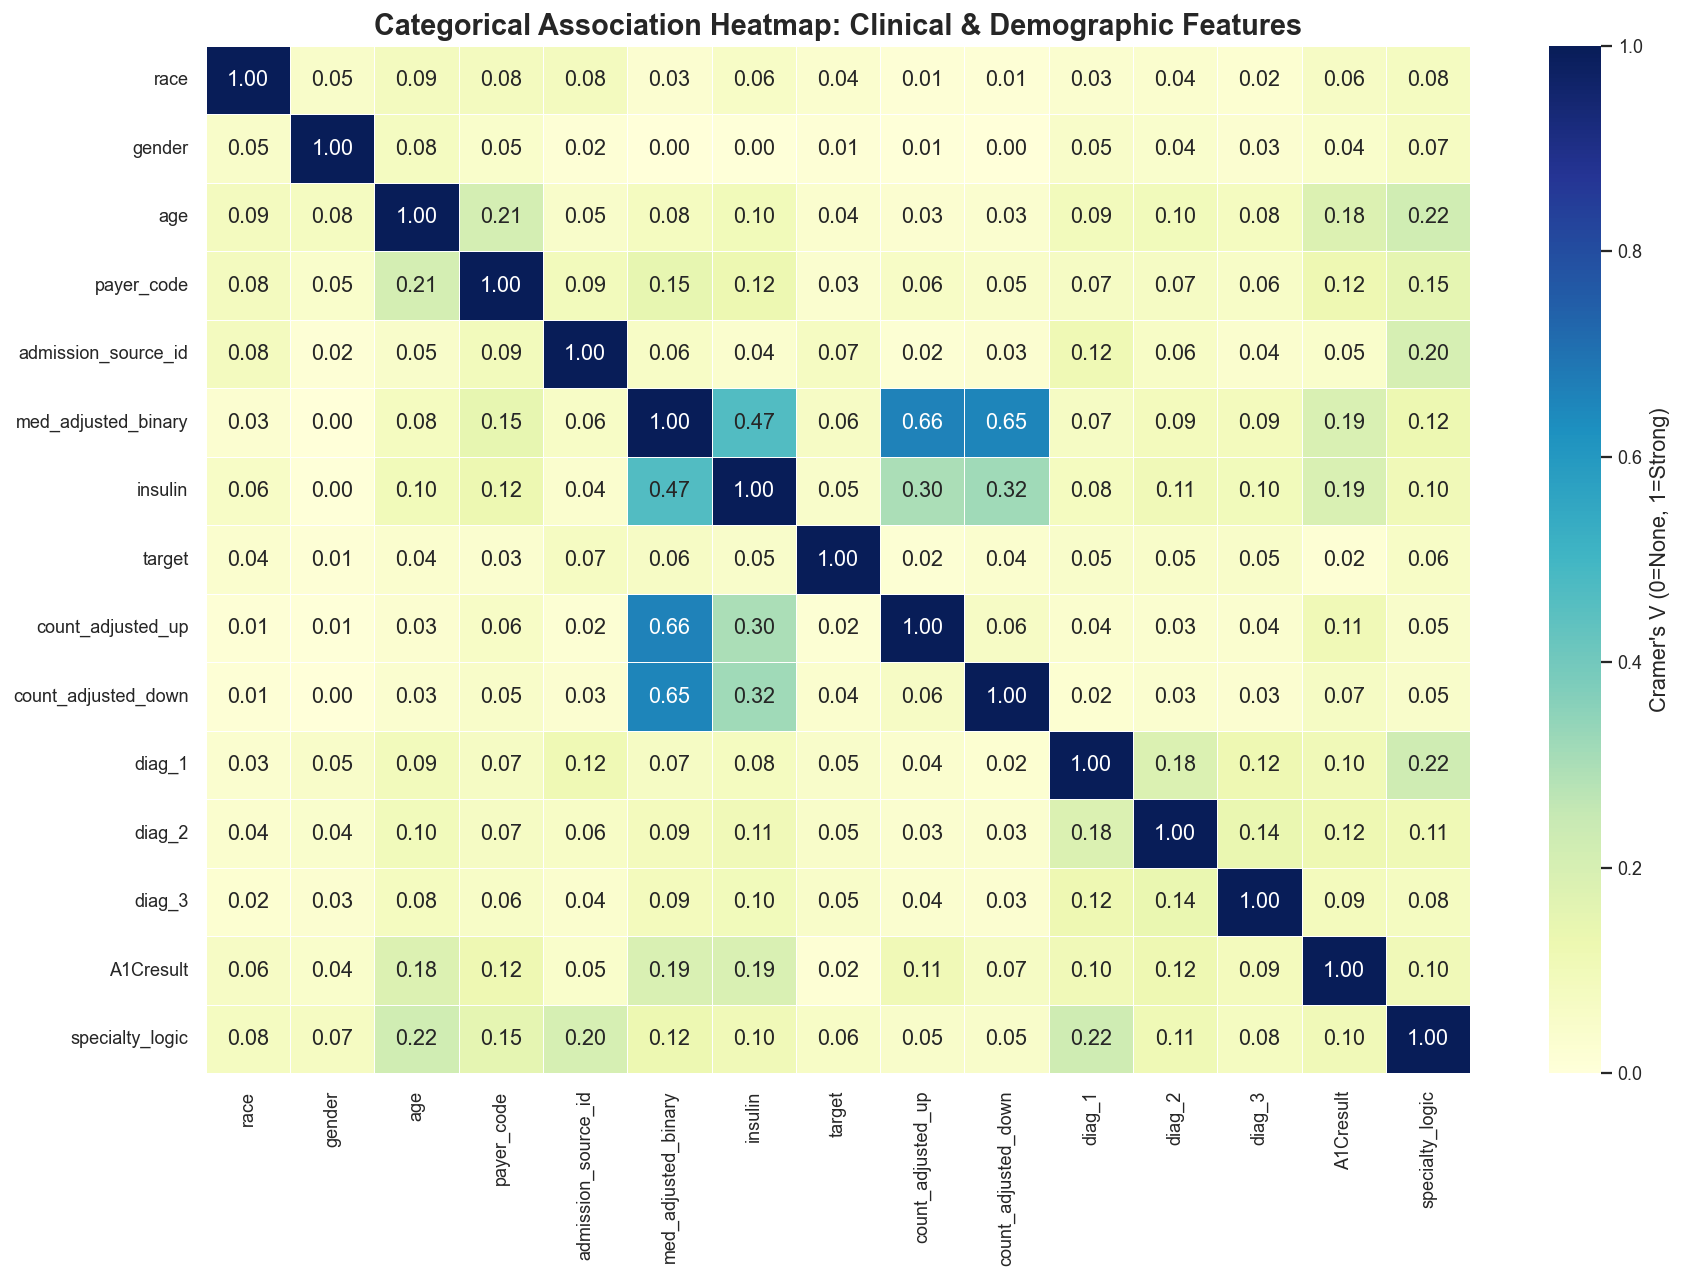

In [66]:
# 1. Map target to numeric for association checks
target_map = {'NO': 0, '>30': 1, '<30': 2}
if 'readmitted' in df_eda.columns:
    df_eda['target'] = df_eda['readmitted'].map(target_map)

assert df_eda['target'].notna().all(), 'Target mapping failed in consolidated EDA frame.'

# 2. Select a practical subset of high-value categorical features
core_cat_cols = [
    'race', 'gender', 'age', 'payer_code', 'admission_source_id',
    'med_adjusted_binary', 'insulin', 'target', 'count_adjusted_up', 'count_adjusted_down',
    'diag_1', 'diag_2', 'diag_3', 'Transfer_Hospital', 'A1Cresult', 'specialty_logic'
]
plot_cols = [col for col in core_cat_cols if col in df_eda.columns]

print(f"Analyzing associations for: {plot_cols}")
v_matrix = plot_cramers_v_heatmap(
    df=df_eda,
    cols=plot_cols,
    save_path=fig_path('05', 'categorical_association_heatmap'),
)
plt.show()

save_table_snapshot(
    v_matrix.reset_index().rename(columns={'index': 'feature'}),
    table_path('05', 'categorical_association_matrix'),
    title="EDA - Categorical Association Matrix (Cramer's V)",
    index=False,
)
v_matrix.to_csv(table_path('05', 'categorical_association_matrix', 'csv'), index=True)


Unified feature influence table (top 50)


,Target_<30,Target_>30,Target_NO,Influence_Score
number_inpatient,0.167208,0.116247,-0.216800,0.500254
number_emergency,0.065763,0.072790,-0.111159,0.249712
number_diagnoses,0.048221,0.087067,-0.113733,0.249021
number_outpatient,0.018000,0.074545,-0.082666,0.175210
admission_source_id_Transfer_Hospital,-0.012059,-0.078907,0.083086,0.174052
patient_nbr,0.008279,0.074121,-0.076120,0.158519
admission_source_id_Emergency_Room,0.017430,0.065516,-0.073670,0.156616
med_adjusted_binary,0.033928,0.042248,-0.061838,0.138015
diabetesMed_No,-0.027210,-0.047833,0.062936,0.137979
diabetesMed_Yes,0.027210,0.047833,-0.062936,0.137979


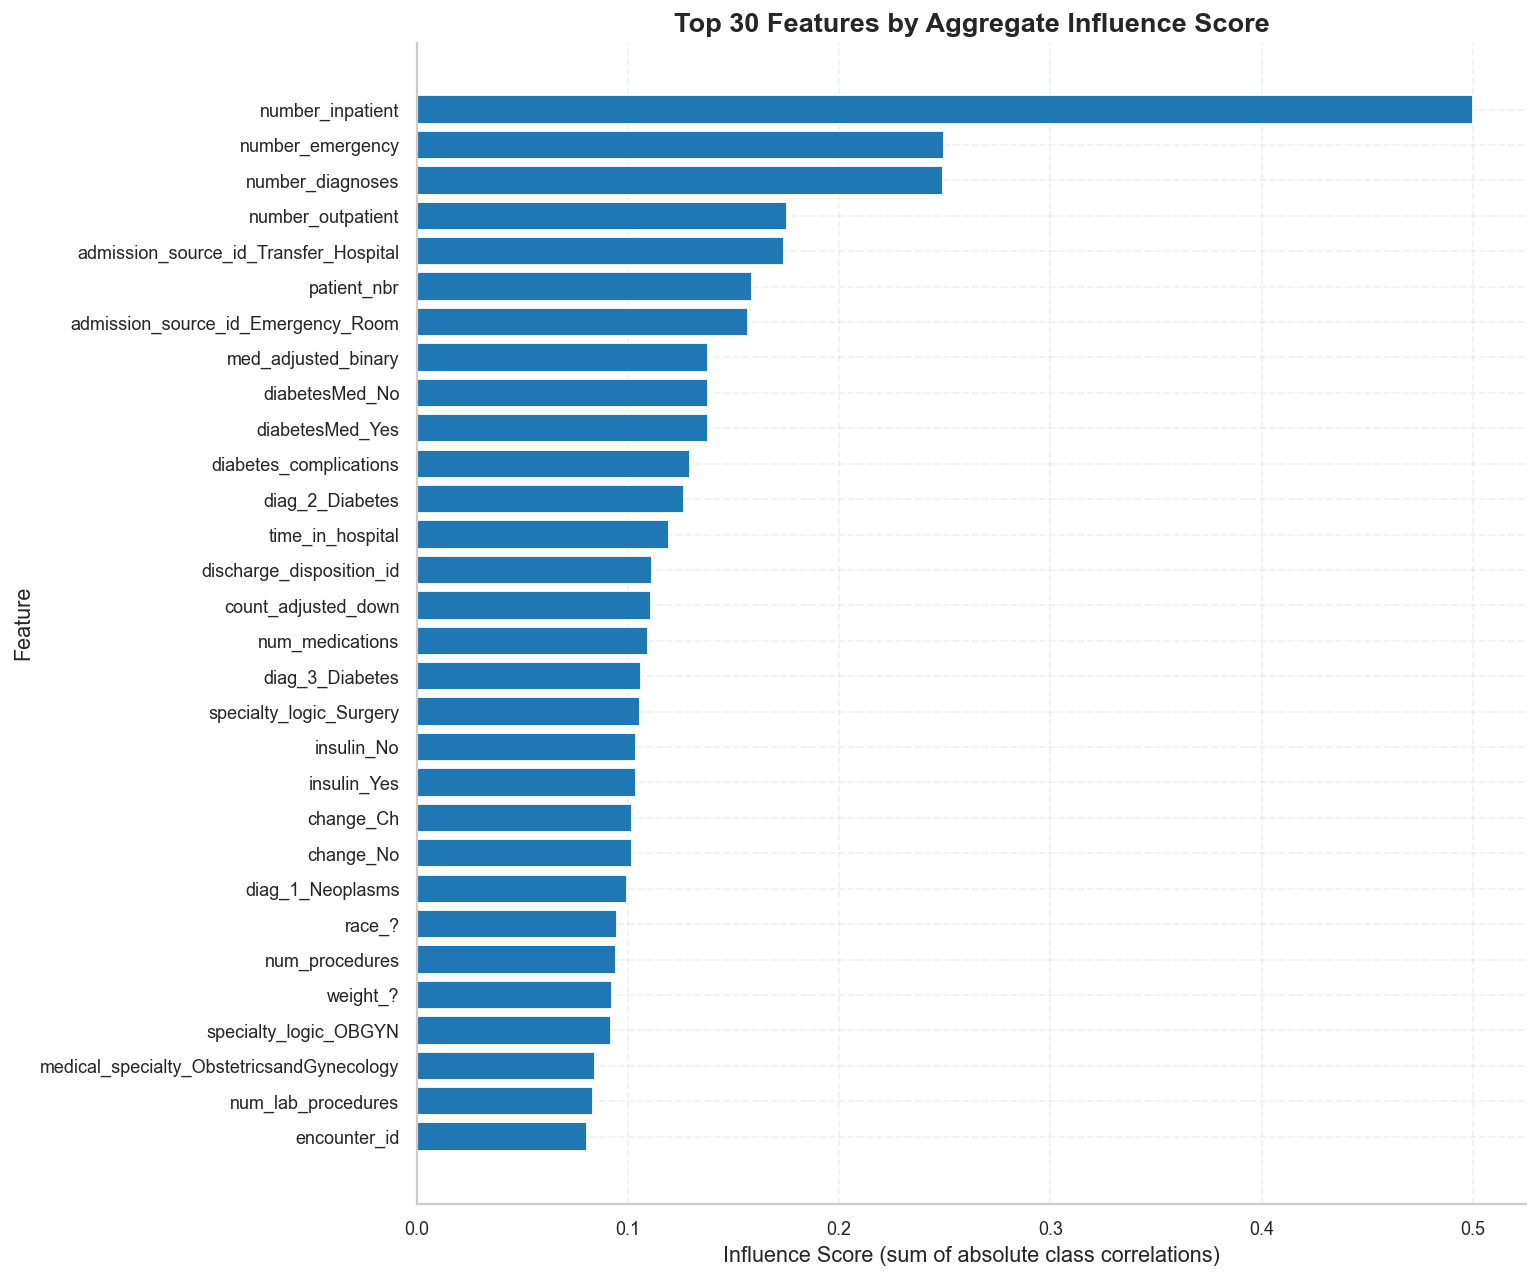

In [67]:
# 1. Unified feature influence table
all_feature_corr = compute_feature_influence_table(df_eda, target_col='readmitted')

# 2. Final table output (top 50)
print('Unified feature influence table (top 50)')
display(all_feature_corr.head(50))

save_table_snapshot(
    all_feature_corr.head(50).reset_index().rename(columns={'index': 'feature'}),
    table_path('05', 'unified_feature_influence_top50'),
    title='EDA - Unified Feature Influence (Top 50)',
    index=False,
)
all_feature_corr.to_csv(table_path('05', 'unified_feature_influence_full', 'csv'), index=True)

# 3. Visual summary of top 30 influence scores
top_30 = all_feature_corr['Influence_Score'].head(30).sort_values(ascending=True)
plt.figure(figsize=(12, 10))
plt.barh(top_30.index, top_30.values, color='#1f77b4')
plt.title('Top 30 Features by Aggregate Influence Score')
plt.xlabel('Influence Score (sum of absolute class correlations)')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(fig_path('05', 'top30_feature_influence_bar'), dpi=220)
plt.show()


## 6. Missing Values & Outliers


### 6.1 Missing Values

Strategy:
1. Drop near-empty columns (`weight`, `max_glu_serum`).
2. Fill operationally missing categories (`medical_specialty`, `payer_code`) with `Unknown`.
3. Handle diagnosis missingness with justified-domain logic.
4. Preserve transparent audit tables for each decision.


In [68]:
# 1. Replace '?' with NaN
df_replaced = data.replace('?', pd.NA)

# 2. Calculate counts and percentages
missing_counts = df_replaced.isnull().sum()
missing_pct = ((missing_counts / len(data)) * 100).round(2)

# 3. Combine into a dataframe
missing_table = pd.concat([missing_counts, missing_pct], axis=1)
missing_table.columns = ['missing_count', 'missing_pct']
missing_table = missing_table[missing_table['missing_count'] > 0].sort_values(
    by='missing_count', ascending=False
)

display(missing_table)

save_table_snapshot(
    missing_table.reset_index().rename(columns={'index': 'feature'}),
    table_path('06', 'missingness_overview'),
    title='EDA - Missingness Overview',
    index=False,
)
missing_table.to_csv(table_path('06', 'missingness_overview', 'csv'))


,missing_count,missing_pct
weight,78822,96.82
max_glu_serum,77162,94.78
A1Cresult,67767,83.24
medical_specialty,39948,49.07
payer_code,32153,39.49
race,1820,2.24
diag_3,1144,1.41
diag_2,286,0.35
diag_1,18,0.02


In [69]:
# 1. Total Missing (count of '?')
total_missing_1 = (data['diag_1'] == '?').sum()
total_missing_2 = (data['diag_2'] == '?').sum()
total_missing_3 = (data['diag_3'] == '?').sum()

# 2. Justified missing (clinical logic)
justified_1 = 0
justified_2 = ((data['diag_2'] == '?') & (data['number_diagnoses'] == 1)).sum()
justified_3 = ((data['diag_3'] == '?') & (data['number_diagnoses'] <= 2)).sum()

# 3. Build audit table
audit_data = {
    'metric': ['total_missing', 'justified_missing', 'unjustified_missing'],
    'diag_1': [total_missing_1, justified_1, total_missing_1 - justified_1],
    'diag_2': [total_missing_2, justified_2, total_missing_2 - justified_2],
    'diag_3': [total_missing_3, justified_3, total_missing_3 - justified_3],
}

audit_df = pd.DataFrame(audit_data).set_index('metric')
display(audit_df)

save_table_snapshot(
    audit_df.reset_index(),
    table_path('06', 'diag_missingness_audit'),
    title='EDA - Diagnosis Missingness Audit',
    index=False,
)
audit_df.to_csv(table_path('06', 'diag_missingness_audit', 'csv'))


,diag_1,diag_2,diag_3
metric,,,
total_missing,18,286,1144
justified_missing,0,170,1000
unjustified_missing,18,116,144


### 6.2 Outlier Detection

#### 6.2.1 Numerical Features - IQR Method


,Column,Lower Bound,Upper Bound,Outlier Count,Percentage (%)
10,has_respiratory,0.00,0.000000e+00,18007,22.12
5,number_outpatient,0.00,0.000000e+00,13392,16.45
13,count_adjusted_up,0.00,0.000000e+00,11425,14.03
14,count_adjusted_down,0.00,0.000000e+00,11252,13.82
6,number_emergency,0.00,0.000000e+00,9066,11.14
11,diabetes_complications,0.00,0.000000e+00,8724,10.72
15,adj_med_ratio,-0.05,8.000000e-02,5877,7.22
7,number_inpatient,-1.50,2.500000e+00,5605,6.88
3,num_procedures,-3.00,5.000000e+00,3989,4.90
4,num_medications,-5.00,3.500000e+01,2053,2.52


/Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/src/styling/plots.py:588: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette="crest", fliersize=5)
/Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/src/styling/plots.py:588: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette="crest", fliersize=5)
/Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/src/styling/plots.py:588: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette="crest", flier

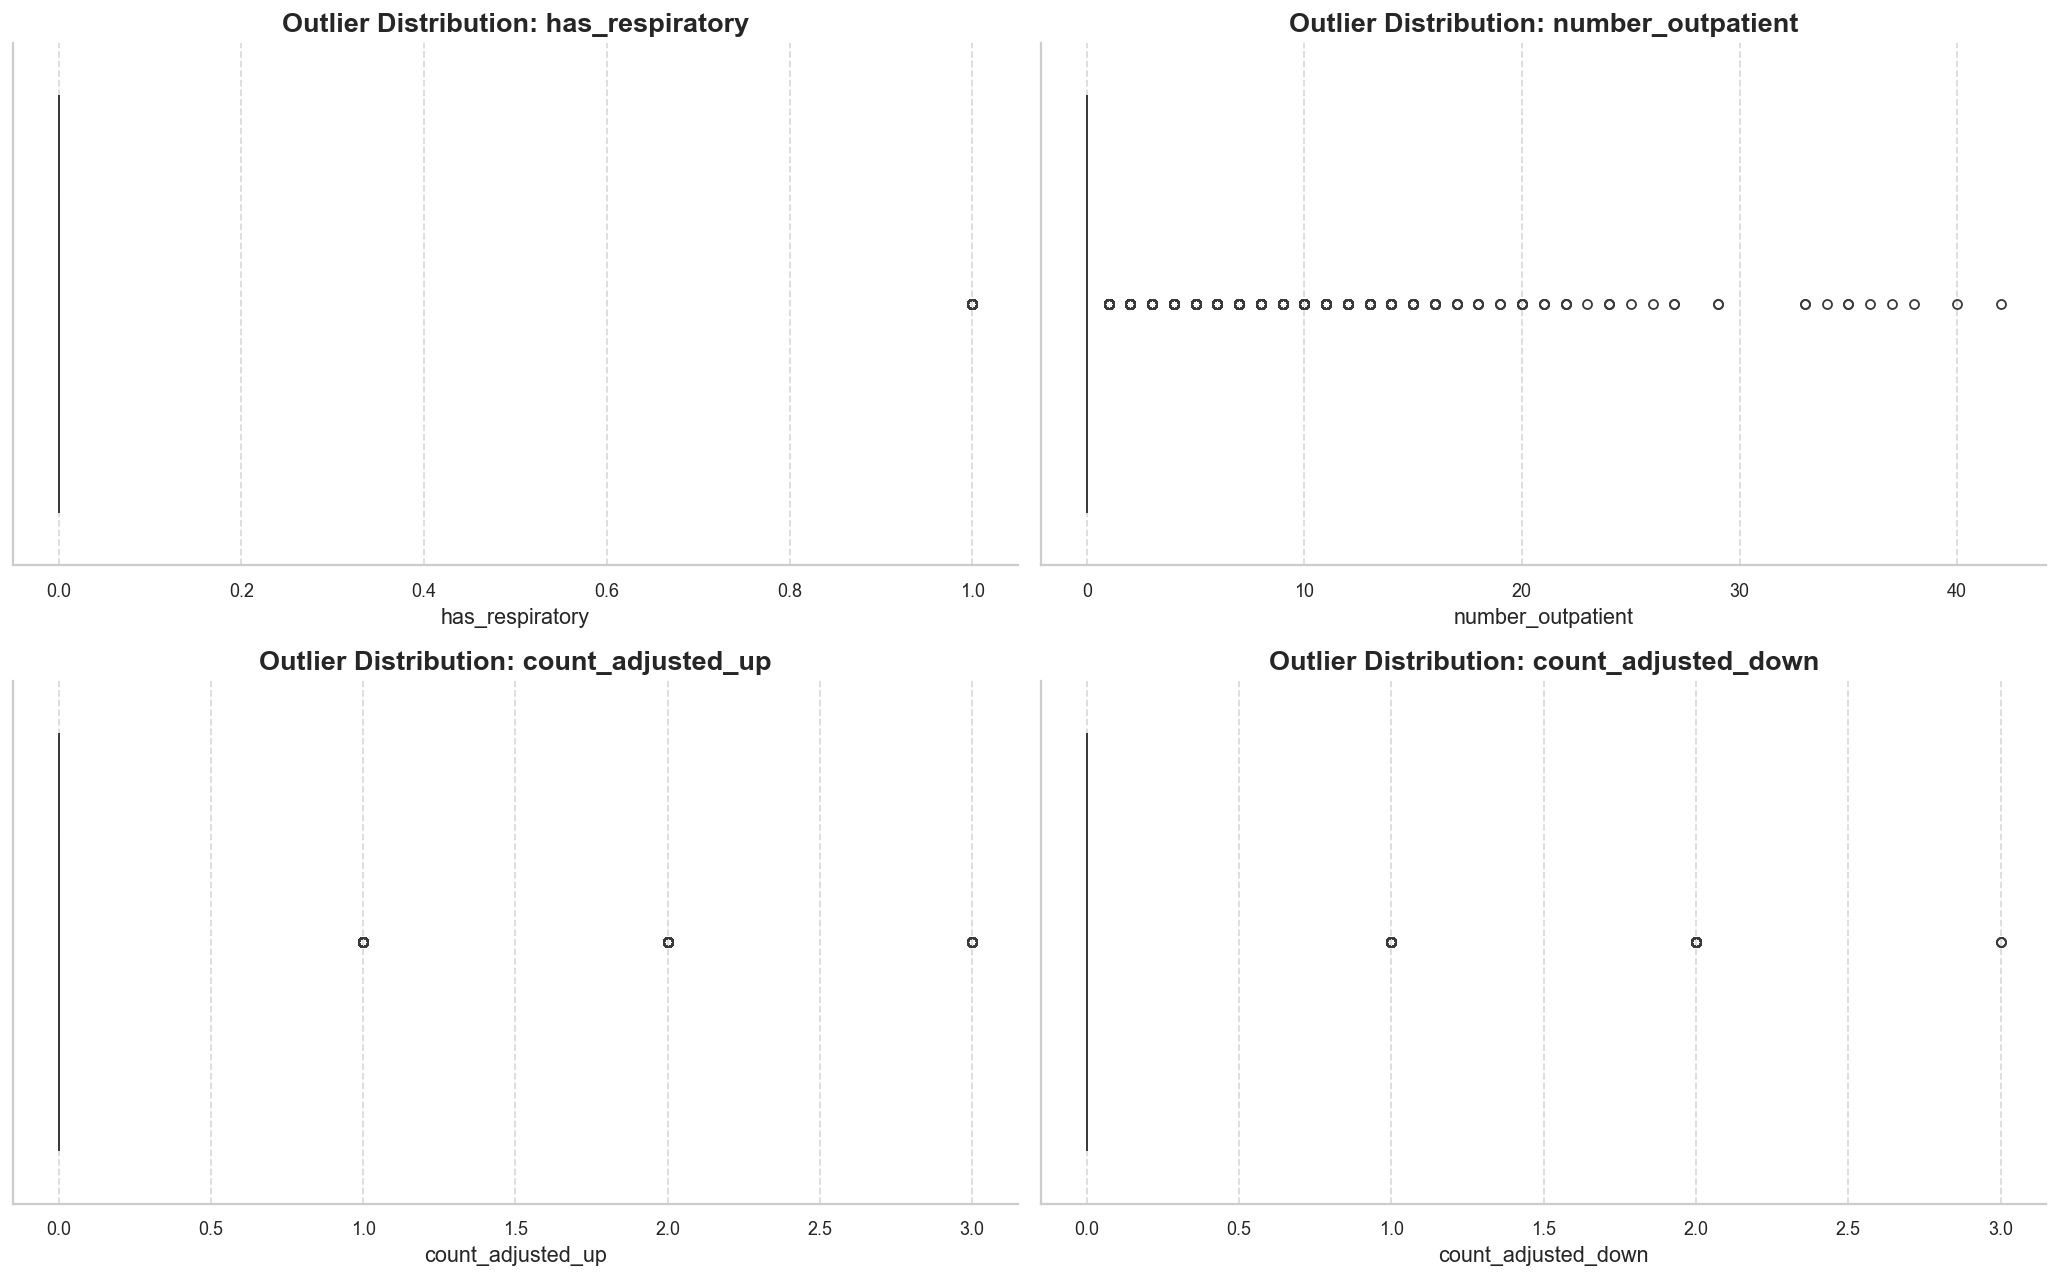

In [70]:
# 1. Identify numeric columns (excluding IDs)
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if 'id' not in col.lower()]

# 2. Generate summary table
outlier_report = get_outlier_summary(df_eda, numeric_cols)
outlier_report = outlier_report.sort_values(by='Percentage (%)', ascending=False)

display(outlier_report)

save_table_snapshot(
    outlier_report,
    table_path('06', 'numeric_outlier_summary'),
    title='EDA - Numeric Outlier Summary (IQR)',
    index=False,
)
outlier_report.to_csv(table_path('06', 'numeric_outlier_summary', 'csv'), index=False)

# 3. Visualize top outlier-heavy features
top_outlier_cols = outlier_report['Column'].head(4).tolist()
plot_top_outlier_boxplots(
    data=df_eda,
    columns=top_outlier_cols,
    save_path=fig_path('06', 'numeric_outlier_boxplots'),
)
plt.show()


#### 6.2.2 Categorial Features

In [71]:
# 1. Configuration
CAT_THRESHOLD = 0.01

# 2. Execute analysis
cat_outlier_summary = analyze_all_categorical_outliers(df_eda, CAT_THRESHOLD)

# 3. Display and persist
if cat_outlier_summary.empty:
    print('No categorical outliers detected at the configured threshold.')
else:
    display(cat_outlier_summary)
    save_table_snapshot(
        cat_outlier_summary,
        table_path('06', 'categorical_outlier_summary'),
        title='EDA - Categorical Rare-Level Summary',
        index=False,
    )
    cat_outlier_summary.to_csv(table_path('06', 'categorical_outlier_summary', 'csv'), index=False)


,Feature,Unique Categories,Rare Categories Count,Rare Categories List,Total Outlier %
5,medical_specialty,69,59,"[Pulmonology, Psychiatry, ObstetricsandGynecol...",8.18
3,weight,10,8,"[[50-75), [100-125), [125-150), [25-50), [0-25...",1.84
19,specialty_logic,10,2,"[OBGYN, Pediatrics]",1.32
2,age,10,2,"[[10-20), [0-10)]",0.84
4,admission_source_id,6,2,"[Court_Law, Transfer_Facility]",0.14
12,miglitol,2,1,[Yes],0.04
18,metformin-pioglitazone,2,1,[Yes],0.00
17,metformin-rosiglitazone,2,1,[Yes],0.00
16,glimepiride-pioglitazone,2,1,[Yes],0.00
15,glipizide-metformin,2,1,[Yes],0.01


## 7. Ethical & Licensing Notes

### 7.1  ⚖️ Ethical Considerations & Data Bias Documentation

| Feature | Potential Bias | Ethical Note |
| :--- | :--- | :--- |
| **Race** | Systemic Inequality | Risk of reinforcing historical healthcare disparities in predictive outcomes. Analysis must ensure models don't penalize groups based on systemic access issues. |
| **Weight** | Data Completeness | Extreme missingness (often >90%) may lead to biased sub-group analysis. Results should not be generalized if the sample is not representative. |
| **Payer Code** | SES Discrimination | Financial status is a proxy for Socio-economic Status (SES). It should not be used to prioritize or deprioritize clinical care or resource allocation. |
| **Gender** | Presentation Bias | Gender-based differences in symptom reporting (e.g., cardiovascular symptoms) may affect "time-in-hospital" metrics and diagnostic accuracy. |

### 7.2 Licensing Notes

The dataset is publicly distributed through UCI with citation requirements. This project uses the data for educational/analytical purposes and does not redistribute protected patient identity information.


## 8. Next-Step Recommendations



## 8.1. Preprocessing Challenges & Potential Biases

1. Moderate single-feature correlations require interaction-aware modeling.
2. Missingness is not random in some operational fields (risk of systematic bias).
3. Payer and race can proxy socioeconomic or structural inequities; monitor fairness metrics.
4. Historical data window (1999-2008) may reduce external validity for current practice.

### Recommended Next Steps After EDA

1. Use selective one-hot encoding only on statistically relevant categorical features.
2. Keep medication behavior as summary signals (`med_was_adjusted`, titration counts), not full raw medication one-hot blocks.
3. Apply skew-aware numeric transforms where right tails are extreme.
4. Build baseline + calibrated models with macro-F1, class recall, and PR analysis.
5. Add fairness slices (race, age, payer group) before deployment decisions.

### Further Action

- Group ultra-rare categories to reduce unstable one-hot columns.
- Cap or transform heavy-tail numeric features before model training.
- Keep both binary and multiclass objectives available for business trade-off analysis.


### Expert To-Do Across the 4 Notebooks

- Add automated data quality gates at notebook start (schema, leakage, class checks).
- Standardize all figure/table file naming with section-prefixed IDs.
- Add reproducibility footer in each notebook: package versions, timestamp, random seed.
- Add notebook-level `assert` checks for critical assumptions (target mapping, no NaNs before training).
- Add confidence-threshold policy simulation linked to clinical workflow constraints.


In [72]:
assert_no_missing_values(df_eda[['target']], 'EDA target helper column')

repro_footer = build_reproducibility_footer(cfg.random_state)
display(repro_footer)
save_table_snapshot(
    repro_footer,
    table_path('99', 'reproducibility_footer'),
    title='EDA - Reproducibility Footer',
    index=False,
)
repro_footer.to_csv(table_path('99', 'reproducibility_footer', 'csv'), index=False)

print(f"Figure artifacts saved to: {output_path}")
print(f"Table artifacts saved to: {table_output_path}")


,timestamp_utc,python_version,platform,random_seed,numpy,pandas,sklearn,matplotlib,seaborn
0,2026-02-18T11:24:42+00:00,3.11.0,macOS-26.2-arm64-arm-64bit,42,1.26.4,2.2.0,1.7.2,3.10.6,0.13.2


Figure artifacts saved to: /Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/output/eda/figures
Table artifacts saved to: /Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/src/eda/tables
